## Imports

In [1]:
import time
import json
import numpy as np
import pandas as pd
from pymatgen.core.periodic_table import Specie
from pymatgen.core.structure import Structure
from tqdm.notebook import tqdm

## Read in JSON for Testing

In [2]:
with open('structures_and_energies/188_ABO3_structures_and_energies_11_tilts.json') as json_file:
    dct = json.load(json_file)
for key in list(dct.keys()):
    dct[key]['structures'] = [Structure.from_dict(s) for s in dct[key]['structures']]

# Benchmark gii_calculator.py

## Compute Matminer GII - Benchmarking

In [3]:
from matminer.featurizers.structure.bonding import GlobalInstabilityIndex
# matminer GlobalInstabilityIndex uses bvparm16.cif, which is the default for GIICalculator

In [4]:
benchmark_structure = dct['NaNbO3']['structures'][1]

In [5]:
start_time = time.time()
mm_gii_calc = GlobalInstabilityIndex(r_cut=4)
mm_gii = mm_gii_calc.featurize(benchmark_structure)[0]
print("Time taken: --- %s seconds ---" % (time.time() - start_time))

Time taken: --- 0.4802548885345459 seconds ---


In [6]:
mm_gii

0.22997194431320916

## Compute GIICalculator GII

In [3]:
from gii_calculator import GIICalculator

In [8]:
start_time = time.time()
#gii_calc = GIICalculator(method='CrystalNN')
gii_calc = GIICalculator(method='Cutoff', cutoff=4)
gii = gii_calc.GII(benchmark_structure)
print("Time taken: --- %s seconds ---" % (time.time() - start_time))

Time taken: --- 0.08210301399230957 seconds ---


In [9]:
gii

0.22997194431320914

In [10]:
gii_calc.params_dict

{'Cation': [Species Na+, Species Nb5+],
 'Anion': [Species O2-, Species O2-],
 'R0': [1.803, 1.911],
 'B': [0.37, 0.37]}

# Benchmark site_optimization.py

## Perform the Site Optimization

In [12]:
from site_optimization import SiteClusterOptimization

In [18]:
sco = SiteClusterOptimization()

In [19]:
start_time = time.time()
final_structure = sco.minimize_cluster_di_squared(benchmark_structure, site_ind=16) # pass the index of site to be optimized
print("Time taken: --- %s seconds ---" % (time.time() - start_time))

Time taken: --- 3.984825849533081 seconds ---


In [20]:
start_time = time.time()
start_gii = gii_calc.GII(benchmark_structure)
print("Time taken: --- %s seconds ---" % (time.time() - start_time))

Time taken: --- 0.14157724380493164 seconds ---


In [21]:
start_gii

0.22741774664473707

In [22]:
start_time = time.time()
final_gii = gii_calc.GII(final_structure, use_sym=False)
print("Time taken: --- %s seconds ---" % (time.time() - start_time))

Time taken: --- 0.3294098377227783 seconds ---


In [23]:
final_gii

0.2222068229123708

## Perform the Structure Optimization 

In [12]:
from site_optimization import GIIMinimizer

In [25]:
gii_minimizer = GIIMinimizer(benchmark_structure, convergence_tolerance=0.01)
# All sites optimized until optimization of said site changes GII by < convergence_tolerance

In [26]:
optimized_structure = gii_minimizer.gii_minimization(opt_method='max')

Step 1 complete; 0.22741774664473727 --> 0.21685468242809414
Step 2 complete; 0.21685468242809414 --> 0.21253671761744256
Step 3 complete; 0.21253671761744256 --> 0.20319583095480914
Step 4 complete; 0.20319583095480914 --> 0.19929305787714166
Step 5 complete; 0.19929305787714166 --> 0.17406125117144214
Step 6 complete; 0.17406125117144214 --> 0.1541425987472521
Step 7 complete; 0.1541425987472521 --> 0.14735253314386446
Step 8 complete; 0.14735253314386446 --> 0.12605574185146776
Step 9 complete; 0.12605574185146776 --> 0.1172540398089425
Step 10 complete; 0.1172540398089425 --> 0.11532954906197346
Step 11 complete; 0.11532954906197346 --> 0.11098630269185894
Step 12 complete; 0.11098630269185894 --> 0.10514996486333666
Step 13 complete; 0.10514996486333666 --> 0.10514996486333666
Step 14 complete; 0.10514996486333666 --> 0.10514996486333666
Step 15 complete; 0.10514996486333666 --> 0.10512042010554813
Step 16 complete; 0.10512042010554813 --> 0.1051185729262532
Step 17 complete; 0.10

In [27]:
# Get the change in GII following optimization for each site in the structure, show that it is < convergence_tolerance
for i in range(len(gii_minimizer.diffs)):
    print('Specie: %s, delGII of optimization step: %s' % (optimized_structure[i].specie, gii_minimizer.diffs[i]))

Specie: Na+, delGII of optimization step: 0.006511574041070112
Specie: Na+, delGII of optimization step: 0.007380391101802525
Specie: Na+, delGII of optimization step: 0.0018892742339008256
Specie: Na+, delGII of optimization step: 0.00614137470116205
Specie: Nb5+, delGII of optimization step: 2.9544757788532716e-05
Specie: Nb5+, delGII of optimization step: 0.0
Specie: Nb5+, delGII of optimization step: 1.847179294925394e-06
Specie: Nb5+, delGII of optimization step: 0.0
Specie: O2-, delGII of optimization step: 0.008801702042525256
Specie: O2-, delGII of optimization step: 0.001924490746969043
Specie: O2-, delGII of optimization step: 0.004343246370114517
Specie: O2-, delGII of optimization step: 0.0058363378285222756
Specie: O2-, delGII of optimization step: 0.006790065603387657
Specie: O2-, delGII of optimization step: 2.7755575615628914e-17
Specie: O2-, delGII of optimization step: 0.002665507676445314
Specie: O2-, delGII of optimization step: 0.0010834205073378123
Specie: O2-, de

# Benchmark parameterization.py

In [11]:
from parameterization import BVParamOptimization
from parameterization import GeneralBVParamOptimizationOuterLoop
from parameterization import CompositionSpecificBVParamOptimizationOuterLoop
from pymatgen.core.periodic_table import Specie

In [12]:
# Define variables and get the starting parameters for cation-anion pairs present

use_cmpd = 'NaNbO3'
cation = Specie('Nb', 5)
anion = Specie('O', -2)
cations_anions = [(Specie('Nb', 5), Specie('O', -2)), (Specie('Na', 1), Specie('O', -2))]
options = {'gtol': 0.01, 'xtol': 0.01, 'barrier_tol': 0.01, 'disp': True, 'verbose': 0} # Changed from default

opt_gii_calc = GIICalculator()
for cmpd in list(dct.keys()):
    s = dct[cmpd]['structures'][0]
    for pair in cations_anions:
        if pair[0] in s.species and pair[1] in s.species:
            opt_gii_calc.GII(s)

## Parameterization that minimizes site discrepancy factor RMSD

### Composition-Specific Parameterization - R0 Only

In [39]:
rmsd_cs_parameterization = CompositionSpecificBVParamOptimizationOuterLoop(dct, [use_cmpd], gii_calc.params_dict)

In [40]:
rmsd_cs_parameterization.parameter_optimization(obj_func='di2_rmsd', parameterize='R0')

0.5308895346573191
0.5308895112541309
0.5308891838870685
63.015576647717445
63.01557672285028
63.01558459206464
0.5282671110507696
0.5282671003017034
0.5282675406421314
0.7404243226939411
0.7404243084034181
0.7404239906841008
0.2954180377835418
0.2954180292579315
0.29541767147706044
0.44558215589695394
0.4455821491725202
0.4455825768390654
0.16583447805799414
0.16583447037603738
0.16583479955750247
0.9158437566387116
0.9158437523431111
0.9158434405088176
0.3635283985563304
0.3635283920154361
0.3635280352789497
0.20315853657454244
0.20315852942325102
0.20315818163988209
`xtol` termination condition is satisfied.
Number of iterations: 10, function evaluations: 30, CG iterations: 11, optimality: 1.11e+01, constraint violation: 0.00e+00, execution time: 6.1e+01 s.
All parameters optimized using convergence criteria


In [41]:
rmsd_cs_parameterization.updated_params_by_composition, rmsd_cs_parameterization.starting_params

({'NaNbO3': {'Cation': [Species Na+, Species Nb5+],
   'Anion': [Species O2-, Species O2-],
   'R0': [1.812, 1.948],
   'B': [0.37, 0.37]}},
 {'Cation': [Species Na+, Species Nb5+],
  'Anion': [Species O2-, Species O2-],
  'R0': [1.803, 1.911],
  'B': [0.37, 0.37]})

### Single Parameter Optimization

In [42]:
single_parameterization_rmsd = BVParamOptimization([dct['NaNbO3']['structures']], [dct['NaNbO3']['energies']], 
                                                          gii_calc.params_dict, [cation], [anion], 
                                                          obj_func='di2_rmsd', options=options)

In [43]:
rmsd_optimized_param_dict = single_parameterization_rmsd.param_optimizer()

0.4251867164064254
0.42518636563617485
63.280137501585074
63.28014550644829
0.4215481128367954
0.4215485418104881
0.6405397907050021
0.6405394588520444
0.1986049751186708
0.1986046088775735
0.34005285300513977
0.3400532733401292
0.06217008191721985
0.06217039318185852
0.7223628056896995
0.7223624811561369
0.22460630986753102
0.22460594448746252
`xtol` termination condition is satisfied.
Number of iterations: 9, function evaluations: 18, CG iterations: 8, optimality: 1.07e+01, constraint violation: 0.00e+00, execution time: 1e+01 s.


In [44]:
rmsd_optimized_param_dict, gii_calc.params_dict

({'Cation': [Species Na+, Species Nb5+],
  'Anion': [Species O2-, Species O2-],
  'R0': [1.803, 1.947],
  'B': [0.37, 0.37]},
 {'Cation': [Species Na+, Species Nb5+],
  'Anion': [Species O2-, Species O2-],
  'R0': [1.803, 1.911],
  'B': [0.37, 0.37]})

### Multiple Parameter Optimization

In [45]:
rmsd_pol = GeneralBVParamOptimizationOuterLoop(dct, cations_anions, opt_gii_calc.params_dict)
rmsd_pol.parameter_optimization(obj_func='di2_rmsd', init_steps=1)

(Species Nb5+, Species O2-) 1
0.4969390575513647
0.4969387160501041
62.294816408595636
62.294824297855406
0.34363124443999804
0.3436316535316038
0.6840425074428501
0.6840421804589454
0.2613087595497971
0.2613084121266947
0.2670507273521087
0.2670511195419649
0.0904857709845064
0.0904857026085591
0.09209978152058317
0.09209988155868214
0.08909100222462095
0.08909100247134066
0.0890909847560686
0.08909098474949245
`gtol` termination condition is satisfied.
Number of iterations: 10, function evaluations: 20, CG iterations: 9, optimality: 2.26e-04, constraint violation: 0.00e+00, execution time: 2.3e+01 s.
1.949 0.37
(Species Na+, Species O2-) 1
0.13569325932729512
0.13569327382202984
0.7659563949669042
0.7659563831005939
0.2544913514129494
0.25449130618335986
0.14056527663663793
0.14056525482565752
0.1334338297270636
0.13343382442091917
0.1330659864098037
0.13306598721757404
0.13305754624328342
0.13305754622897045
`gtol` termination condition is satisfied.
Number of iterations: 7, functio

In [46]:
rmsd_pol.starting_params

{'Cation': [Species Na+,
  Species Nb5+,
  Species Sb5+,
  Species Ta5+,
  Species W5+,
  Species Ag+],
 'Anion': [Species O2-,
  Species O2-,
  Species O2-,
  Species O2-,
  Species O2-,
  Species O2-],
 'R0': [1.803, 1.911, 1.912, 1.92, 1.881, 1.842],
 'B': [0.37, 0.37, 0.37, 0.37, 0.37, 0.37]}

In [47]:
rmsd_pol.updated_params

{'Cation': [Species Na+,
  Species Nb5+,
  Species Sb5+,
  Species Ta5+,
  Species W5+,
  Species Ag+],
 'Anion': [Species O2-,
  Species O2-,
  Species O2-,
  Species O2-,
  Species O2-,
  Species O2-],
 'R0': [1.793, 1.949, 1.912, 1.92, 1.881, 1.842],
 'B': [0.37, 0.37, 0.37, 0.37, 0.37, 0.37]}

## Parameterization considering GII-DFT Energetics Relationship

### Composition-Specific Parameterization

In [31]:
gs_cs_parameterization = CompositionSpecificBVParamOptimizationOuterLoop(dct, [use_cmpd], gii_calc.params_dict)

In [32]:
gs_cs_parameterization.parameter_optimization(obj_func='gii_gs')

0.8759271965561727
0.8759270114046712
0.8759272979182438
0.9970649010355069
0.997064900735736
0.9970649013574377
0.9581090510603086
0.9581089885304245
0.9581091037970134
0.9493711118565613
0.949371030490742
0.9493711789234135
0.8799701953456404
0.8799699466098394
0.8799705224470059
0.9702919813944775
0.9702919619256541
0.9702920029424218
0.9561926342495858
0.9561925776816448
0.9561926801096746
0.9347960660080918
0.9347959418044921
0.9347961348487588
0.9523393502424893
0.9523392528798112
0.9523394259009775
0.6920518486763058
0.6920513261740705
0.6920518901729429
0.8778407975826956
0.8778405160533279
0.8778412054640523
0.8277399648027359
0.8277395774707722
0.8277404653086947
0.8600146867128924
0.8600143266834223
0.8600148477239995
0.8504086349470362
0.8504082583889168
0.850408889016567
0.8500255609987467
0.8500251844500756
0.8500258304032184
0.931128287105023
0.9311281058911738
0.9311284435754681
0.9449883725067338
0.9449882302040133
0.9449885570234362
0.9435776352470792
0.94357749939077

In [50]:
gs_cs_parameterization.updated_params_by_composition, gs_cs_parameterization.starting_params

({'NaNbO3': {'Cation': [Species Na+, Species Nb5+],
   'Anion': [Species O2-, Species O2-],
   'R0': [1.802, 1.945],
   'B': [0.37, 0.37]}},
 {'Cation': [Species Na+, Species Nb5+],
  'Anion': [Species O2-, Species O2-],
  'R0': [1.803, 1.911],
  'B': [0.37, 0.37]})

### Single Parameter Optimization

In [52]:
single_parameterization_gii = BVParamOptimization([dct['NaNbO3']['structures']], [dct['NaNbO3']['energies']], 
                                                         gii_calc.params_dict, [cation], [anion], options=options)

In [53]:
gii_optimized_param_dict = single_parameterization_gii.param_optimizer()

0.8759271965561727
0.8759272979182438
0.9967800101556453
0.9967800108992403
0.9619289177254557
0.9619289733733777
0.984418093510638
0.9844181018430954
0.9836163600494846
0.9836163664459969
0.9827209932647463
0.982721000745698
0.9335406405642902
0.9335407078168376
0.9974258203794442
0.9974258205344567
0.9418518786446923
0.9418519455268382
0.9972529524684045
0.997252952763292
0.9625979157353322
0.9625980930116182
0.9955935986250433
0.9955936005956567
0.9794640807542064
0.9794641566457716
`gtol` termination condition is satisfied.
Number of iterations: 10, function evaluations: 26, CG iterations: 9, optimality: 8.28e-04, constraint violation: 0.00e+00, execution time: 2.7e+01 s.


In [54]:
gii_optimized_param_dict, gii_calc.params_dict

({'Cation': [Species Na+, Species Nb5+],
  'Anion': [Species O2-, Species O2-],
  'R0': [1.803, 1.948],
  'B': [0.37, 0.37]},
 {'Cation': [Species Na+, Species Nb5+],
  'Anion': [Species O2-, Species O2-],
  'R0': [1.803, 1.911],
  'B': [0.37, 0.37]})

### Multiple Parameter Optimization

In [11]:
# gii_pol = GeneralBVParamOptimizationOuterLoop(dct, cations_anions, opt_gii_calc.params_dict)

In [12]:
# gii_pol.parameter_optimization(init_steps=1, max_steps=3)

# Testing analysis.py

In [9]:
from analysis import stats

In [15]:
def print_stats(gs_giis, pearsons, correctly_ordered, correctly_identified_gs):
    print('Number of gii_gs <= 0.1: %s/%s' % (str(np.sum([1 for gs_gii in gs_giis if gs_gii <= 0.1])), len(gs_giis)))
    print('Number of ground states correctly identified by GII: %s' % str(correctly_identified_gs[0]))
    print('Minimum Pearson: %s' % str(sorted(pearsons)[1]))
    print('N >= 8: %s' % str(np.sum([1 for co in correctly_ordered if co >= 8])))

## Composition-Specific Distributions

In [15]:
from visualization import plot_giis_pearsons

### p = 0.65

In [3]:
with open('optimized_parameters/59_cs_11_tilts_p_0.65_optimized_parameters.json') as json_file:
    cs_065_params_dct = json.load(json_file)
for cmpd in list(cs_065_params_dct.keys()):
    cs_065_params_dct[cmpd]['Cation'] = [Specie.from_dict(s) for s in cs_065_params_dct[cmpd]['Cation']]
    cs_065_params_dct[cmpd]['Anion'] = [Specie.from_dict(s) for s in cs_065_params_dct[cmpd]['Anion']]

In [40]:
gs_giis_065, pearsons_065, correctly_ordered_065, correctly_identified_gs_065, cmpds_used_065 = stats(dct, cs_065_params_dct)

 55%|████████████████████████████████████████████▊                                    | 104/188 [02:48<02:26,  1.74s/it]

NaWO3 min_gii 0.254
NaWO3 pearson 0.652


 96%|█████████████████████████████████████████████████████████████████████████████▌   | 180/188 [04:57<00:13,  1.68s/it]

YbAlO3 pearson 0.232


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [05:10<00:00,  1.65s/it]


In [13]:
from visualization import plot_giis_pearsons

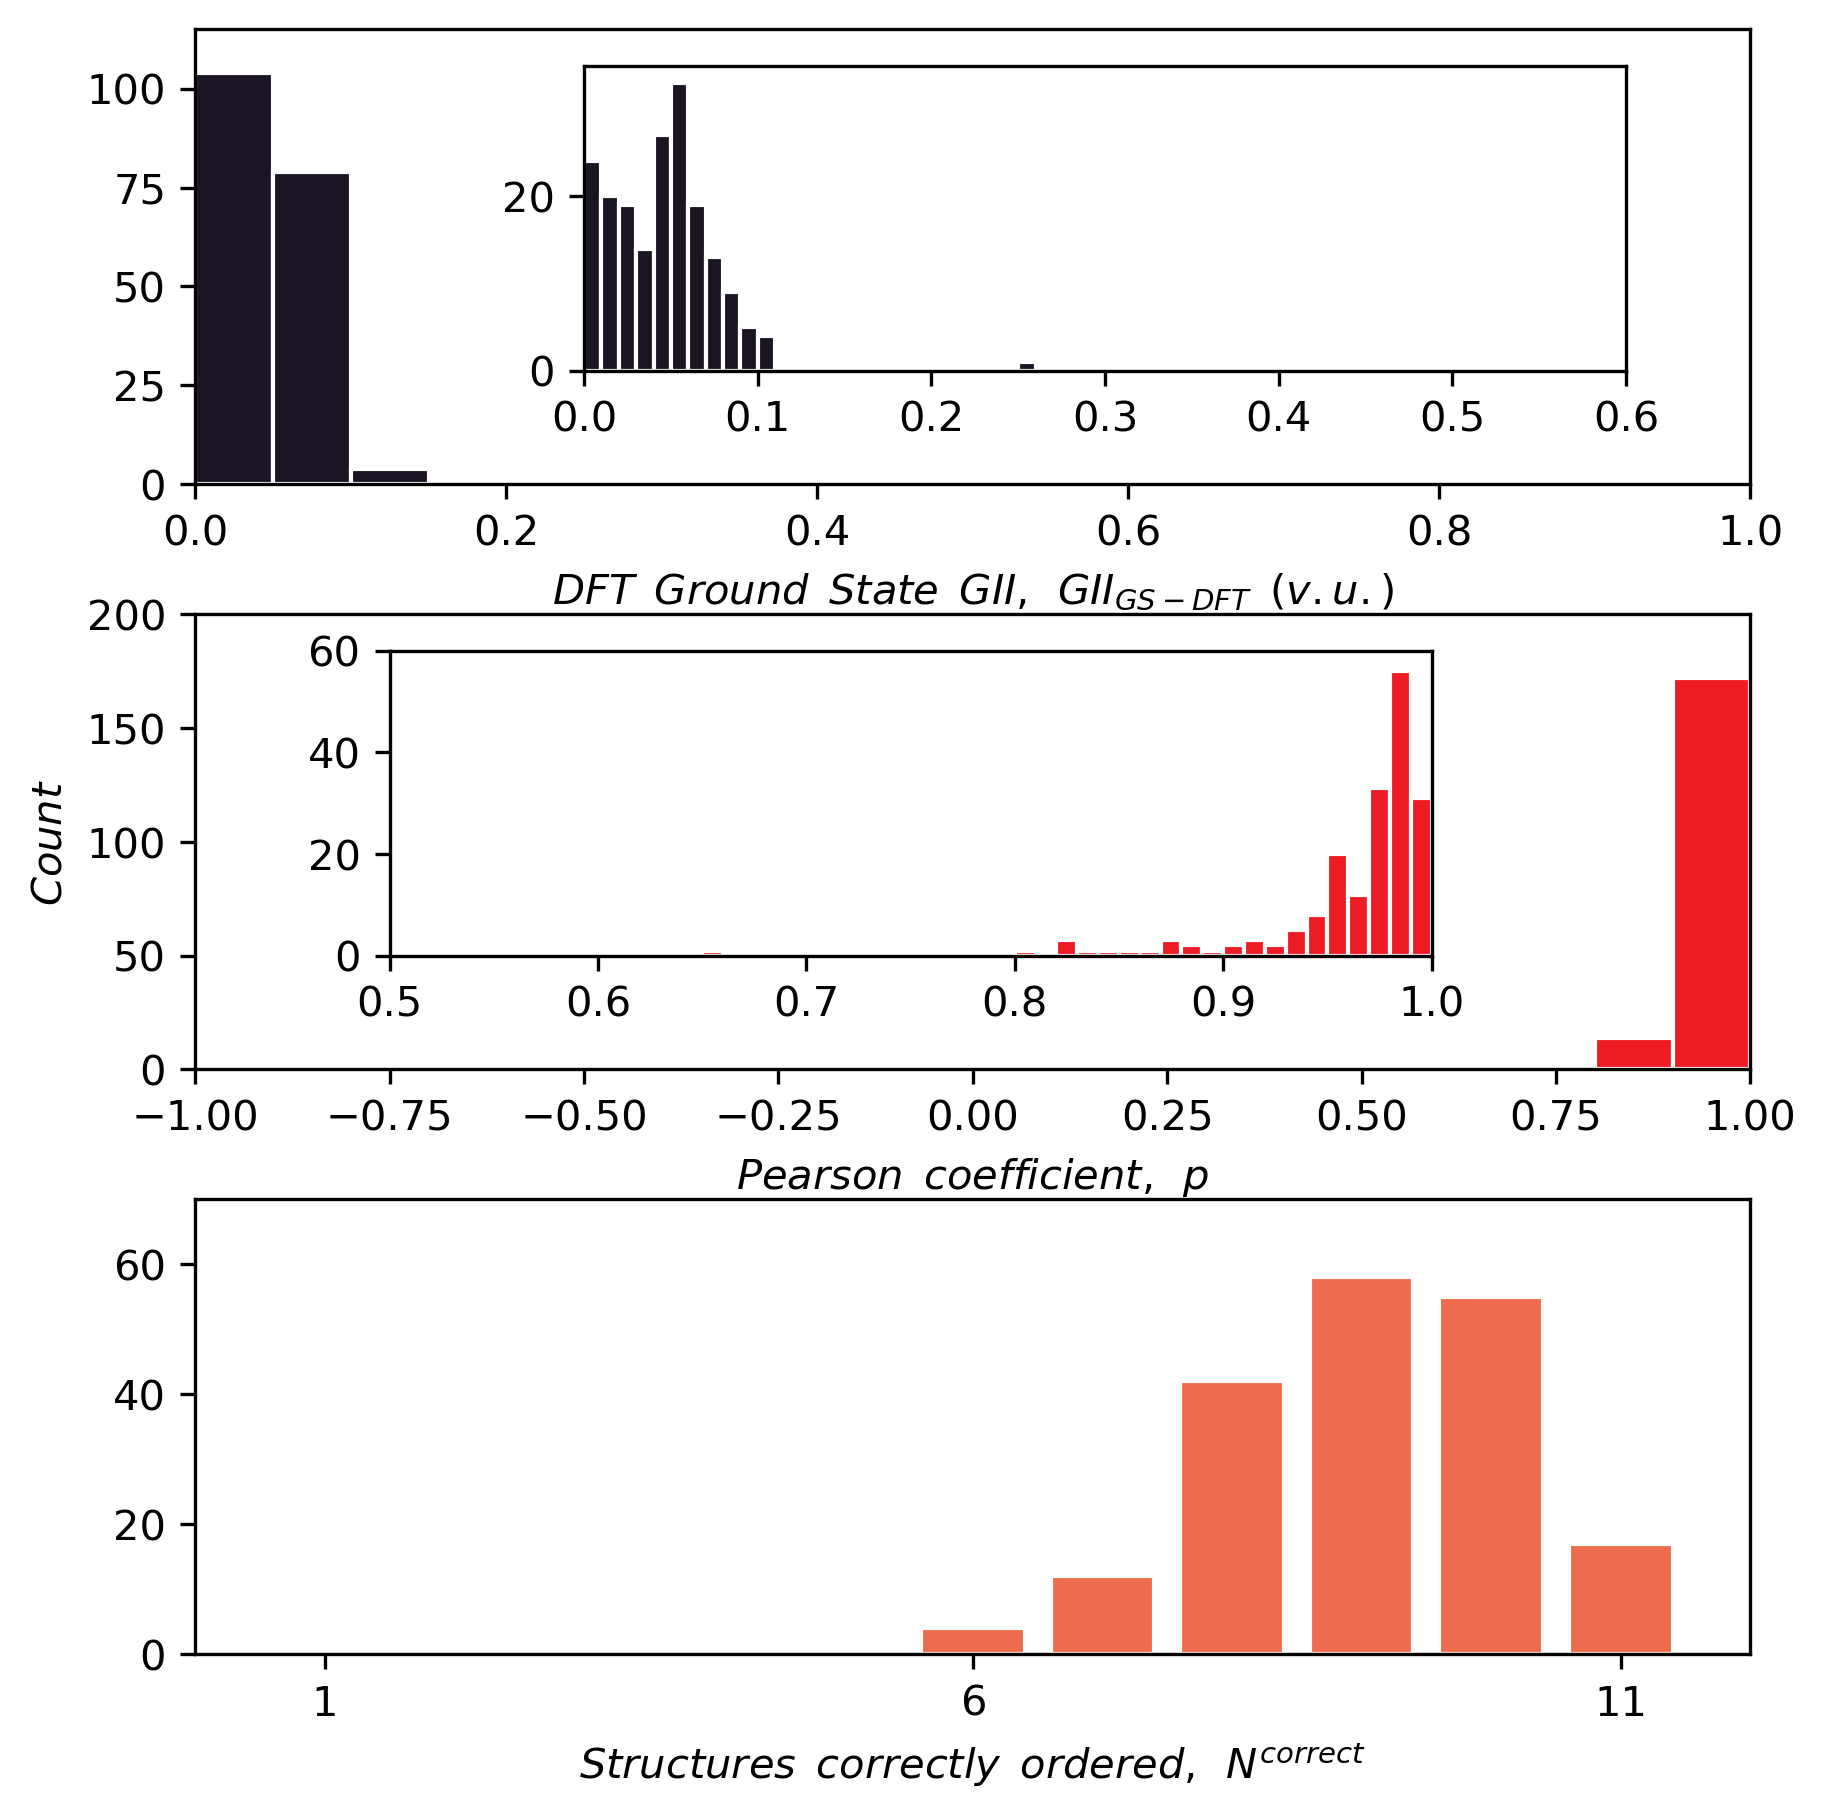

In [42]:
plot_giis_pearsons(gs_giis_065, pearsons_065, correctly_ordered_065, name='figures/composition_specific_distribution.png')

In [43]:
print_stats(gs_giis_065, pearsons_065, correctly_ordered_065, correctly_identified_gs_065)

Number of gii_gs <= 0.1: 183/188
Number of ground states correctly identified by GII: 174
Minimum Pearson: 0.652
N >= 8: 172


## Composition-Specific Plotting

In [5]:
from visualization import plot_by_species

DyCoO3 0.078 0.953 7
GdCoO3 0.063 0.942 7
HoCoO3 0.078 0.944 6
NdCoO3 0.039 0.85 7
PrCoO3 0.034 0.862 8
SmCoO3 0.068 0.915 9
TbCoO3 0.079 0.952 8
YCoO3 0.077 0.972 8


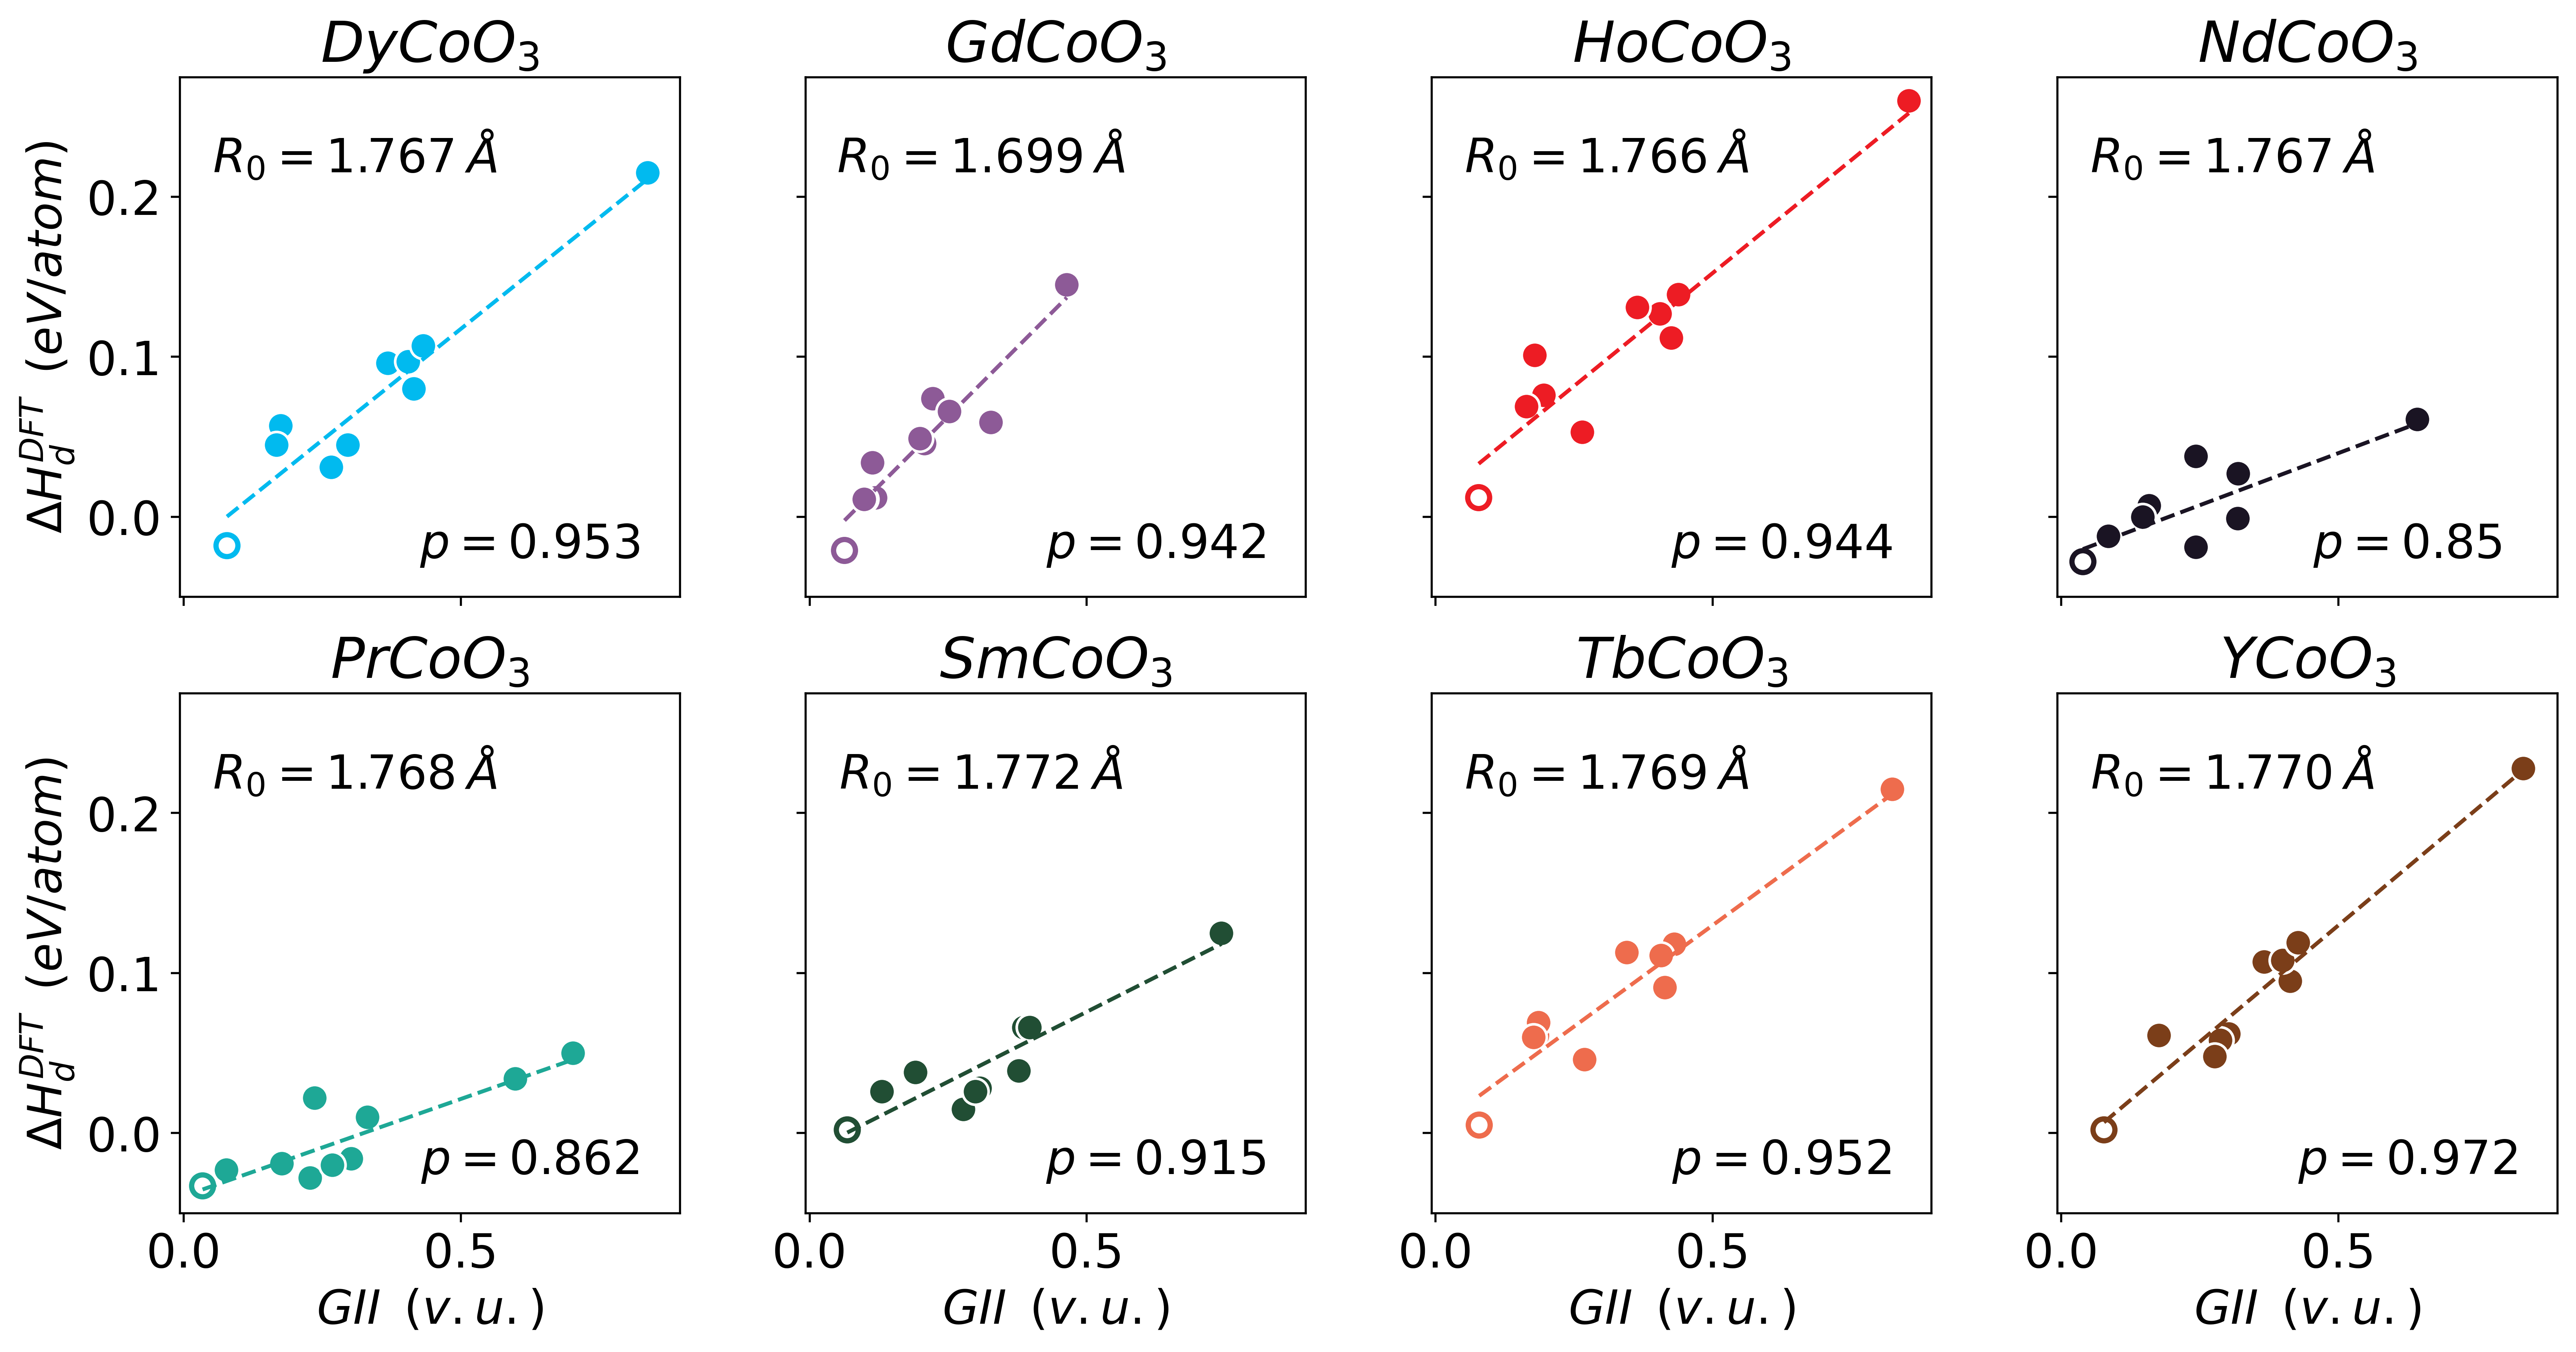

In [22]:
pair = (Specie('Co', 3), Specie('O', -2))
plot_by_species(pair, dct, cs_065_params_dct, name='figures/composition_specific_GII_dHd.png')

## General Distributions

## p = 0.7

In [3]:
with open('optimized_parameters/59_g_11_tilts_p_0.7_optimized_parameters_0.01_6.json') as json_file:
    g_07_params_dct = json.load(json_file)

g_07_params_dct['Cation'] = [Specie.from_dict(s) for s in g_07_params_dct['Cation']]
g_07_params_dct['Anion'] = [Specie.from_dict(s) for s in g_07_params_dct['Anion']]

In [17]:
g_gs_giis_07, g_pearsons_07, g_correctly_ordered_07, g_correctly_identified_gs_07, g_cmpds_used_07 = stats(dct, g_07_params_dct)

  1%|▍                                                                                  | 1/188 [00:02<06:58,  2.24s/it]

AlBiO3 pearson -0.067


 11%|█████████▏                                                                        | 21/188 [00:46<05:55,  2.13s/it]

CeFeO3 pearson -0.145


 14%|███████████▎                                                                      | 26/188 [00:56<05:34,  2.07s/it]

CeVO3 pearson 0.634


 28%|███████████████████████                                                           | 53/188 [01:53<04:47,  2.13s/it]

EuTiO3 min_gii 0.346


 30%|████████████████████████▍                                                         | 56/188 [02:00<04:48,  2.19s/it]

GdCoO3 min_gii 0.333


 46%|█████████████████████████████████████▌                                            | 86/188 [03:04<03:39,  2.15s/it]

LaNiO3 pearson 0.653


 55%|████████████████████████████████████████████▊                                    | 104/188 [03:42<03:09,  2.25s/it]

NaWO3 min_gii 0.38
NaWO3 pearson 0.691


 56%|█████████████████████████████████████████████▋                                   | 106/188 [03:47<03:08,  2.29s/it]

NdAlO3 pearson 0.696


 63%|██████████████████████████████████████████████████▊                              | 118/188 [04:12<02:31,  2.17s/it]

PrAlO3 pearson 0.676


 78%|███████████████████████████████████████████████████████████████▎                 | 147/188 [05:14<01:29,  2.18s/it]

SrIrO3 min_gii 0.258
SrIrO3 pearson 0.521


 80%|█████████████████████████████████████████████████████████████████                | 151/188 [05:23<01:21,  2.20s/it]

SrRuO3 pearson 0.519


 96%|█████████████████████████████████████████████████████████████████████████████▌   | 180/188 [06:28<00:17,  2.16s/it]

YbAlO3 min_gii 0.238
YbAlO3 pearson -0.238


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 181/188 [06:30<00:14,  2.04s/it]

YbCeO3 min_gii 0.371


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 182/188 [06:32<00:12,  2.09s/it]

YbCrO3 min_gii 0.395


 97%|██████████████████████████████████████████████████████████████████████████████▊  | 183/188 [06:34<00:10,  2.13s/it]

YbFeO3 min_gii 0.475


 98%|███████████████████████████████████████████████████████████████████████████████▎ | 184/188 [06:36<00:08,  2.17s/it]

YbMnO3 min_gii 0.509


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 185/188 [06:39<00:06,  2.16s/it]

YbNiO3 min_gii 0.268
YbNiO3 pearson 0.233


 99%|████████████████████████████████████████████████████████████████████████████████▌| 187/188 [06:42<00:02,  2.09s/it]

YbTiO3 min_gii 0.386


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [06:45<00:00,  2.16s/it]


In [18]:
print_stats(g_gs_giis_07, g_pearsons_07, g_correctly_ordered_07, g_correctly_identified_gs_07)

Number of gii_gs <= 0.1: 140/188
Number of ground states correctly identified by GII: 120
Minimum Pearson: -0.145
N >= 8: 152


## p = 0.8

In [6]:
with open('optimized_parameters/59_g_11_tilts_p_0.8_optimized_parameters_0.01_6.json') as json_file:
    g_08_params_dct = json.load(json_file)

g_08_params_dct['Cation'] = [Specie.from_dict(s) for s in g_08_params_dct['Cation']]
g_08_params_dct['Anion'] = [Specie.from_dict(s) for s in g_08_params_dct['Anion']]

In [11]:
g_gs_giis_08, g_pearsons_08, g_correctly_ordered_08, g_correctly_identified_gs_08, g_cmpds_used_08 = stats(dct, g_08_params_dct)

  1%|▍                                                                                  | 1/188 [00:02<07:24,  2.38s/it]

AlBiO3 pearson 0.484


 11%|█████████▏                                                                        | 21/188 [00:46<05:53,  2.12s/it]

CeFeO3 min_gii 0.236
CeFeO3 pearson 0.5


 12%|█████████▌                                                                        | 22/188 [00:48<05:55,  2.14s/it]

CeGaO3 min_gii 0.229


 12%|██████████                                                                        | 23/188 [00:50<05:35,  2.03s/it]

CeLuO3 min_gii 0.301


 13%|██████████▉                                                                       | 25/188 [00:54<05:22,  1.98s/it]

CeTmO3 min_gii 0.262


 26%|█████████████████████▎                                                            | 49/188 [01:45<05:02,  2.17s/it]

EuMnO3 min_gii 0.21


 28%|███████████████████████                                                           | 53/188 [01:53<04:45,  2.12s/it]

EuTiO3 min_gii 0.354


 30%|████████████████████████▍                                                         | 56/188 [02:00<04:48,  2.19s/it]

GdCoO3 min_gii 0.334


 55%|████████████████████████████████████████████▊                                    | 104/188 [03:42<03:10,  2.27s/it]

NaWO3 min_gii 0.592


 78%|███████████████████████████████████████████████████████████████▎                 | 147/188 [05:13<01:28,  2.17s/it]

SrIrO3 min_gii 0.265
SrIrO3 pearson 0.6


 96%|█████████████████████████████████████████████████████████████████████████████▌   | 180/188 [06:26<00:16,  2.10s/it]

YbAlO3 min_gii 0.347
YbAlO3 pearson -0.23


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 181/188 [06:28<00:13,  1.99s/it]

YbCeO3 min_gii 0.22


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 182/188 [06:30<00:12,  2.09s/it]

YbCrO3 min_gii 0.404


 97%|██████████████████████████████████████████████████████████████████████████████▊  | 183/188 [06:33<00:10,  2.13s/it]

YbFeO3 min_gii 0.498


 98%|███████████████████████████████████████████████████████████████████████████████▎ | 184/188 [06:35<00:08,  2.17s/it]

YbMnO3 min_gii 0.509


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 185/188 [06:37<00:06,  2.16s/it]

YbNiO3 min_gii 0.255
YbNiO3 pearson 0.407


 99%|████████████████████████████████████████████████████████████████████████████████▏| 186/188 [06:39<00:04,  2.04s/it]

YbPrO3 min_gii 0.213


 99%|████████████████████████████████████████████████████████████████████████████████▌| 187/188 [06:41<00:02,  2.08s/it]

YbTiO3 min_gii 0.444


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [06:43<00:00,  2.15s/it]


## TM3d/Ln3 Number

In [4]:
from analysis import get_correct_gs_Ln3_Tm3

In [7]:
gs_total, gs_two_total, correct = get_correct_gs_Ln3_Tm3(dct, g_08_params_dct)

  0%|                                                                                           | 0/188 [00:00<?, ?it/s]

CeCrO3


 11%|████████▋                                                                         | 20/188 [00:02<00:16,  9.91it/s]

CeFeO3


 11%|█████████▏                                                                        | 21/188 [00:03<00:35,  4.69it/s]

CeTiO3


 13%|██████████▍                                                                       | 24/188 [00:05<00:50,  3.22it/s]

CeVO3


 14%|███████████▎                                                                      | 26/188 [00:07<01:08,  2.36it/s]

DyCoO3


 15%|████████████▏                                                                     | 28/188 [00:09<01:27,  1.83it/s]

DyCrO3


 15%|████████████▋                                                                     | 29/188 [00:11<01:54,  1.39it/s]

DyFeO3


 16%|█████████████                                                                     | 30/188 [00:13<02:21,  1.12it/s]

DyMnO3


 16%|█████████████▌                                                                    | 31/188 [00:15<02:48,  1.07s/it]

DyNiO3


 17%|█████████████▉                                                                    | 32/188 [00:17<03:15,  1.25s/it]

DyScO3


 18%|██████████████▊                                                                   | 34/188 [00:19<02:50,  1.10s/it]

DyTiO3


 19%|███████████████▎                                                                  | 35/188 [00:20<03:12,  1.26s/it]

DyVO3


 19%|███████████████▋                                                                  | 36/188 [00:22<03:33,  1.41s/it]

ErCrO3


 20%|████████████████▌                                                                 | 38/188 [00:24<03:04,  1.23s/it]

ErFeO3


 21%|█████████████████                                                                 | 39/188 [00:26<03:24,  1.37s/it]

ErMnO3


 21%|█████████████████▍                                                                | 40/188 [00:28<03:39,  1.48s/it]

ErNiO3


 22%|█████████████████▉                                                                | 41/188 [00:30<03:59,  1.63s/it]

ErTiO3


 23%|██████████████████▊                                                               | 43/188 [00:32<03:13,  1.33s/it]

ErVO3


 23%|███████████████████▏                                                              | 44/188 [00:34<03:28,  1.45s/it]

EuCrO3


 24%|████████████████████                                                              | 46/188 [00:36<03:00,  1.27s/it]

EuFeO3


 25%|████████████████████▌                                                             | 47/188 [00:38<03:21,  1.43s/it]

EuMnO3


 26%|█████████████████████▎                                                            | 49/188 [00:40<02:55,  1.26s/it]

EuNiO3


 27%|█████████████████████▊                                                            | 50/188 [00:42<03:16,  1.42s/it]

EuScO3


 28%|██████████████████████▋                                                           | 52/188 [00:43<02:43,  1.20s/it]

EuTiO3


 28%|███████████████████████                                                           | 53/188 [00:45<03:04,  1.37s/it]

GdCoO3


 30%|████████████████████████▍                                                         | 56/188 [00:47<02:16,  1.03s/it]

GdCrO3


 30%|████████████████████████▊                                                         | 57/188 [00:49<02:33,  1.18s/it]

GdFeO3


 31%|█████████████████████████▎                                                        | 58/188 [00:51<02:52,  1.33s/it]

GdMnO3


 32%|██████████████████████████▏                                                       | 60/188 [00:53<02:34,  1.20s/it]

GdNiO3


 32%|██████████████████████████▌                                                       | 61/188 [00:55<02:53,  1.36s/it]

GdScO3


 34%|███████████████████████████▍                                                      | 63/188 [00:57<02:25,  1.17s/it]

GdTiO3


 34%|███████████████████████████▉                                                      | 64/188 [00:59<02:45,  1.33s/it]

GdVO3


 35%|████████████████████████████▎                                                     | 65/188 [01:01<03:00,  1.47s/it]

HoCoO3


 36%|█████████████████████████████▋                                                    | 68/188 [01:03<02:06,  1.06s/it]

HoCrO3


 37%|██████████████████████████████                                                    | 69/188 [01:04<02:25,  1.22s/it]

HoFeO3


 37%|██████████████████████████████▌                                                   | 70/188 [01:06<02:39,  1.35s/it]

HoMnO3


 38%|██████████████████████████████▉                                                   | 71/188 [01:08<02:53,  1.48s/it]

HoNiO3


 38%|███████████████████████████████▍                                                  | 72/188 [01:10<03:08,  1.63s/it]

HoScO3


 39%|████████████████████████████████▎                                                 | 74/188 [01:12<02:26,  1.29s/it]

HoTiO3


 40%|████████████████████████████████▋                                                 | 75/188 [01:14<02:40,  1.42s/it]

LaCrO3


 41%|█████████████████████████████████▌                                                | 77/188 [01:16<02:18,  1.25s/it]

LaCuO3


 41%|██████████████████████████████████                                                | 78/188 [01:18<02:35,  1.42s/it]

LaFeO3


 43%|██████████████████████████████████▉                                               | 80/188 [01:20<02:14,  1.25s/it]

LaMnO3


 45%|█████████████████████████████████████                                             | 85/188 [01:22<01:17,  1.32it/s]

LaNiO3


 46%|█████████████████████████████████████▌                                            | 86/188 [01:24<01:35,  1.07it/s]

LaScO3


 47%|██████████████████████████████████████▊                                           | 89/188 [01:25<01:20,  1.23it/s]

LaTiO3


 48%|███████████████████████████████████████▎                                          | 90/188 [01:27<01:36,  1.01it/s]

LaVO3


 49%|████████████████████████████████████████▏                                         | 92/188 [01:30<01:38,  1.03s/it]

LuCrO3


 51%|█████████████████████████████████████████▍                                        | 95/188 [01:32<01:20,  1.16it/s]

LuFeO3


 51%|█████████████████████████████████████████▊                                        | 96/188 [01:33<01:32,  1.01s/it]

LuMnO3


 52%|██████████████████████████████████████████▎                                       | 97/188 [01:35<01:45,  1.16s/it]

LuTiO3


 52%|██████████████████████████████████████████▋                                       | 98/188 [01:37<01:55,  1.29s/it]

NdCoO3


 57%|██████████████████████████████████████████████                                   | 107/188 [01:39<00:41,  1.98it/s]

NdCrO3


 57%|██████████████████████████████████████████████▌                                  | 108/188 [01:41<00:52,  1.52it/s]

NdFeO3


 58%|██████████████████████████████████████████████▉                                  | 109/188 [01:43<01:05,  1.21it/s]

NdMnO3


 60%|████████████████████████████████████████████████▎                                | 112/188 [01:45<00:58,  1.30it/s]

NdNiO3


 60%|████████████████████████████████████████████████▋                                | 113/188 [01:47<01:12,  1.04it/s]

NdScO3


 61%|█████████████████████████████████████████████████▌                               | 115/188 [01:49<01:08,  1.06it/s]

NdTiO3


 62%|█████████████████████████████████████████████████▉                               | 116/188 [01:51<01:20,  1.12s/it]

NdVO3


 62%|██████████████████████████████████████████████████▍                              | 117/188 [01:53<01:31,  1.28s/it]

PrCoO3


 63%|███████████████████████████████████████████████████▎                             | 119/188 [01:55<01:22,  1.19s/it]

PrCrO3


 64%|███████████████████████████████████████████████████▋                             | 120/188 [01:57<01:32,  1.35s/it]

PrFeO3


 64%|████████████████████████████████████████████████████▏                            | 121/188 [01:59<01:40,  1.50s/it]

PrMnO3


 66%|█████████████████████████████████████████████████████▍                           | 124/188 [02:01<01:09,  1.09s/it]

PrNiO3


 66%|█████████████████████████████████████████████████████▊                           | 125/188 [02:03<01:19,  1.26s/it]

PrScO3


 68%|███████████████████████████████████████████████████████▏                         | 128/188 [02:04<00:57,  1.04it/s]

PrTiO3


 69%|███████████████████████████████████████████████████████▌                         | 129/188 [02:06<01:07,  1.14s/it]

PrVO3


 69%|████████████████████████████████████████████████████████                         | 130/188 [02:08<01:16,  1.33s/it]

SmCoO3


 72%|██████████████████████████████████████████████████████████▏                      | 135/188 [02:11<00:42,  1.24it/s]

SmCrO3


 72%|██████████████████████████████████████████████████████████▌                      | 136/188 [02:13<00:50,  1.02it/s]

SmFeO3


 73%|███████████████████████████████████████████████████████████                      | 137/188 [02:15<00:58,  1.14s/it]

SmMnO3


 74%|███████████████████████████████████████████████████████████▉                     | 139/188 [02:17<00:53,  1.09s/it]

SmNiO3


 74%|████████████████████████████████████████████████████████████▎                    | 140/188 [02:19<01:00,  1.27s/it]

SmScO3


 76%|█████████████████████████████████████████████████████████████▏                   | 142/188 [02:20<00:52,  1.13s/it]

SmTiO3


 76%|█████████████████████████████████████████████████████████████▌                   | 143/188 [02:22<00:58,  1.30s/it]

SmVO3


 77%|██████████████████████████████████████████████████████████████                   | 144/188 [02:24<01:03,  1.44s/it]

TbCoO3


 83%|███████████████████████████████████████████████████████████████████▏             | 156/188 [02:26<00:13,  2.31it/s]

TbCrO3


 84%|███████████████████████████████████████████████████████████████████▋             | 157/188 [02:28<00:17,  1.77it/s]

TbFeO3


 84%|████████████████████████████████████████████████████████████████████             | 158/188 [02:30<00:21,  1.39it/s]

TbMnO3


 85%|████████████████████████████████████████████████████████████████████▌            | 159/188 [02:32<00:25,  1.13it/s]

TbTiO3


 86%|█████████████████████████████████████████████████████████████████████▎           | 161/188 [02:34<00:24,  1.11it/s]

TmCrO3


 88%|███████████████████████████████████████████████████████████████████████▌         | 166/188 [02:36<00:14,  1.57it/s]

TmFeO3


 89%|███████████████████████████████████████████████████████████████████████▉         | 167/188 [02:38<00:16,  1.27it/s]

TmNiO3


 89%|████████████████████████████████████████████████████████████████████████▍        | 168/188 [02:40<00:19,  1.04it/s]

TmTiO3


 90%|████████████████████████████████████████████████████████████████████████▊        | 169/188 [02:42<00:21,  1.12s/it]

YbCrO3


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 182/188 [02:44<00:02,  2.63it/s]

YbFeO3


 97%|██████████████████████████████████████████████████████████████████████████████▊  | 183/188 [02:46<00:02,  1.97it/s]

YbMnO3


 98%|███████████████████████████████████████████████████████████████████████████████▎ | 184/188 [02:48<00:02,  1.49it/s]

YbNiO3


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 185/188 [02:50<00:02,  1.21it/s]

YbTiO3


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [02:52<00:00,  1.09it/s]


In [8]:
gs_total, gs_two_total, correct

(75, 80, 89)

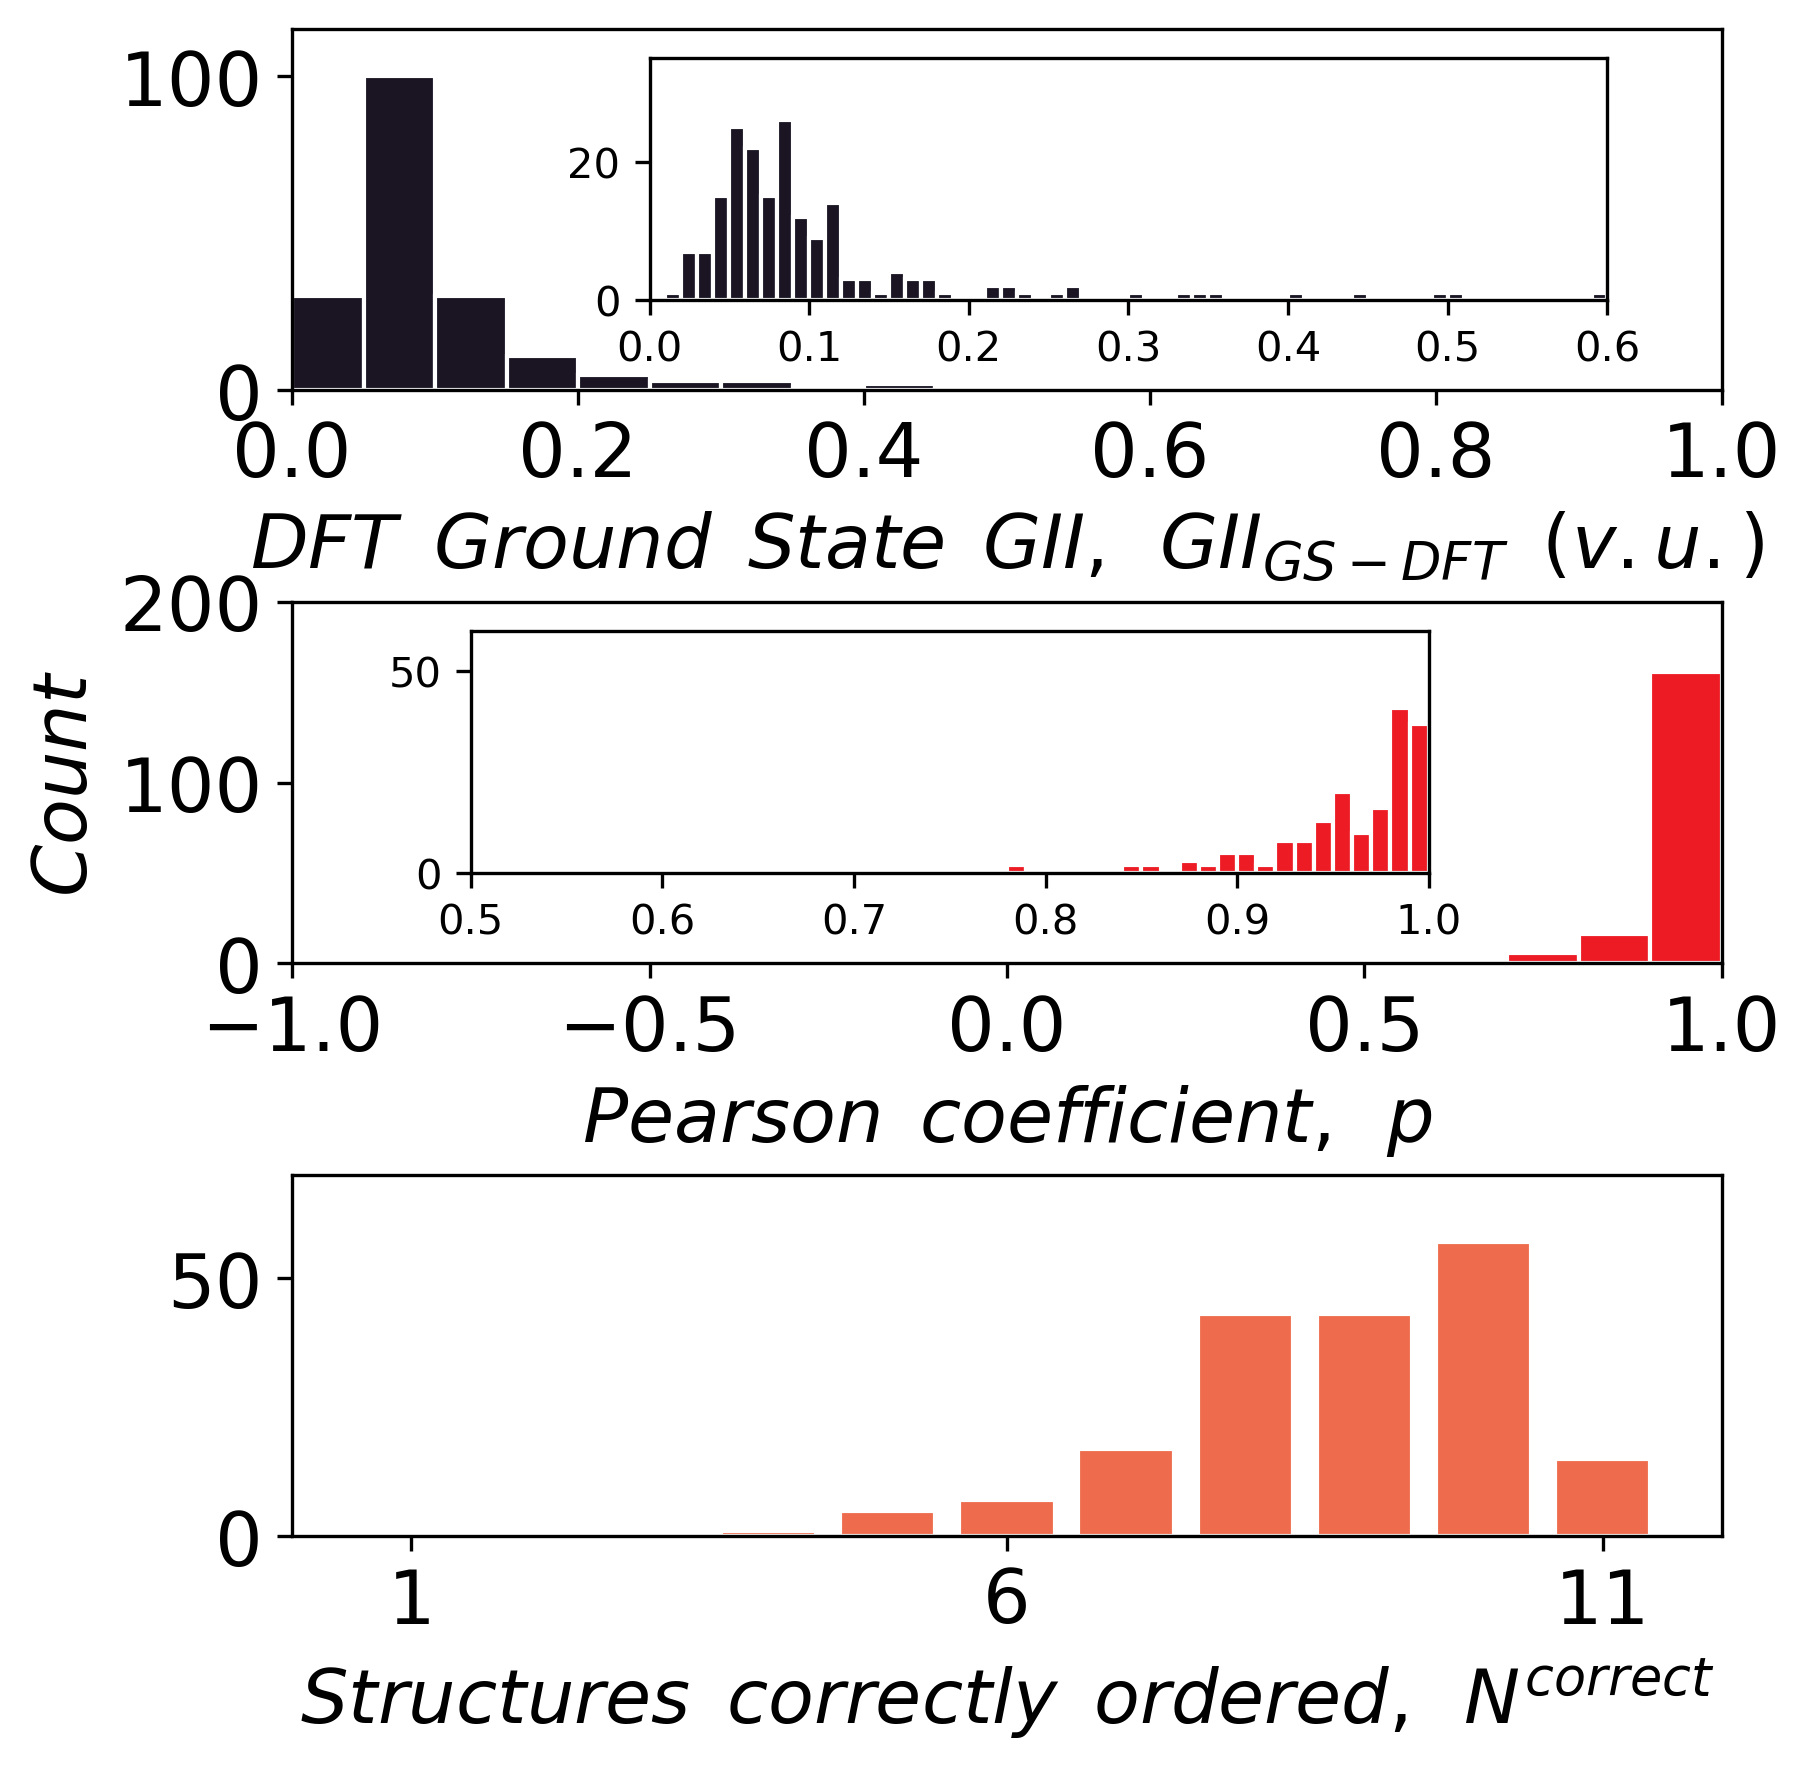

In [14]:
plot_giis_pearsons(g_gs_giis_08, g_pearsons_08, g_correctly_ordered_08, name='figures/general_distribution.png')

In [15]:
print_stats(g_gs_giis_08, g_pearsons_08, g_correctly_ordered_08, g_correctly_identified_gs_08)

Number of gii_gs <= 0.1: 130/188
Number of ground states correctly identified by GII: 135
Minimum Pearson: 0.407
N >= 8: 158


In [22]:
g_correctly_identified_gs_08

[135, 17, 7, 12, 5, 2, 0, 2, 4, 4, 0]

## p = 0.85

In [19]:
with open('optimized_parameters/59_g_11_tilts_p_0.85_optimized_parameters_0.01_6.json') as json_file:
    g_085_params_dct = json.load(json_file)

g_085_params_dct['Cation'] = [Specie.from_dict(s) for s in g_085_params_dct['Cation']]
g_085_params_dct['Anion'] = [Specie.from_dict(s) for s in g_085_params_dct['Anion']]

In [20]:
g_gs_giis_085, g_pearsons_085, g_correctly_ordered_085, g_correctly_identified_gs_085, g_cmpds_used_085 = stats(dct, g_085_params_dct)

 11%|█████████▏                                                                        | 21/188 [00:46<05:51,  2.10s/it]

CeFeO3 pearson 0.2


 12%|██████████                                                                        | 23/188 [00:49<05:33,  2.02s/it]

CeLuO3 min_gii 0.235


 26%|█████████████████████▎                                                            | 49/188 [01:45<05:04,  2.19s/it]

EuMnO3 min_gii 0.208


 28%|███████████████████████                                                           | 53/188 [01:53<04:44,  2.11s/it]

EuTiO3 min_gii 0.352


 30%|████████████████████████▍                                                         | 56/188 [02:00<04:47,  2.18s/it]

GdCoO3 min_gii 0.338


 50%|█████████████████████████████████████████                                         | 94/188 [03:19<03:00,  1.92s/it]

LaYbO3 min_gii 1.449


 55%|████████████████████████████████████████████▊                                    | 104/188 [03:41<03:10,  2.26s/it]

NaWO3 min_gii 0.818


 78%|███████████████████████████████████████████████████████████████▎                 | 147/188 [05:13<01:29,  2.19s/it]

SrIrO3 min_gii 0.276
SrIrO3 pearson 0.685


 96%|█████████████████████████████████████████████████████████████████████████████▌   | 180/188 [06:27<00:17,  2.14s/it]

YbAlO3 min_gii 1.414
YbAlO3 pearson -0.282


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 181/188 [06:28<00:14,  2.03s/it]

YbCeO3 min_gii 1.404


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 182/188 [06:31<00:12,  2.09s/it]

YbCrO3 min_gii 1.405


 97%|██████████████████████████████████████████████████████████████████████████████▊  | 183/188 [06:33<00:10,  2.13s/it]

YbFeO3 min_gii 1.416


 98%|███████████████████████████████████████████████████████████████████████████████▎ | 184/188 [06:35<00:08,  2.18s/it]

YbMnO3 min_gii 1.411


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 185/188 [06:37<00:06,  2.19s/it]

YbNiO3 min_gii 1.402


 99%|████████████████████████████████████████████████████████████████████████████████▏| 186/188 [06:39<00:04,  2.09s/it]

YbPrO3 min_gii 1.466


 99%|████████████████████████████████████████████████████████████████████████████████▌| 187/188 [06:41<00:02,  2.12s/it]

YbTiO3 min_gii 1.413


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [06:44<00:00,  2.15s/it]


In [21]:
print_stats(g_gs_giis_085, g_pearsons_085, g_correctly_ordered_085, g_correctly_identified_gs_085)

Number of gii_gs <= 0.1: 119/188
Number of ground states correctly identified by GII: 141
Minimum Pearson: 0.2
N >= 8: 162


## General Plotting

## p = 0.8

DyCoO3 0.09 0.943 7
GdCoO3 0.334 0.722 5
HoCoO3 0.089 0.932 6
NdCoO3 0.056 0.833 7
PrCoO3 0.046 0.855 8
SmCoO3 0.08 0.907 9
TbCoO3 0.088 0.942 7
YCoO3 0.096 0.956 8


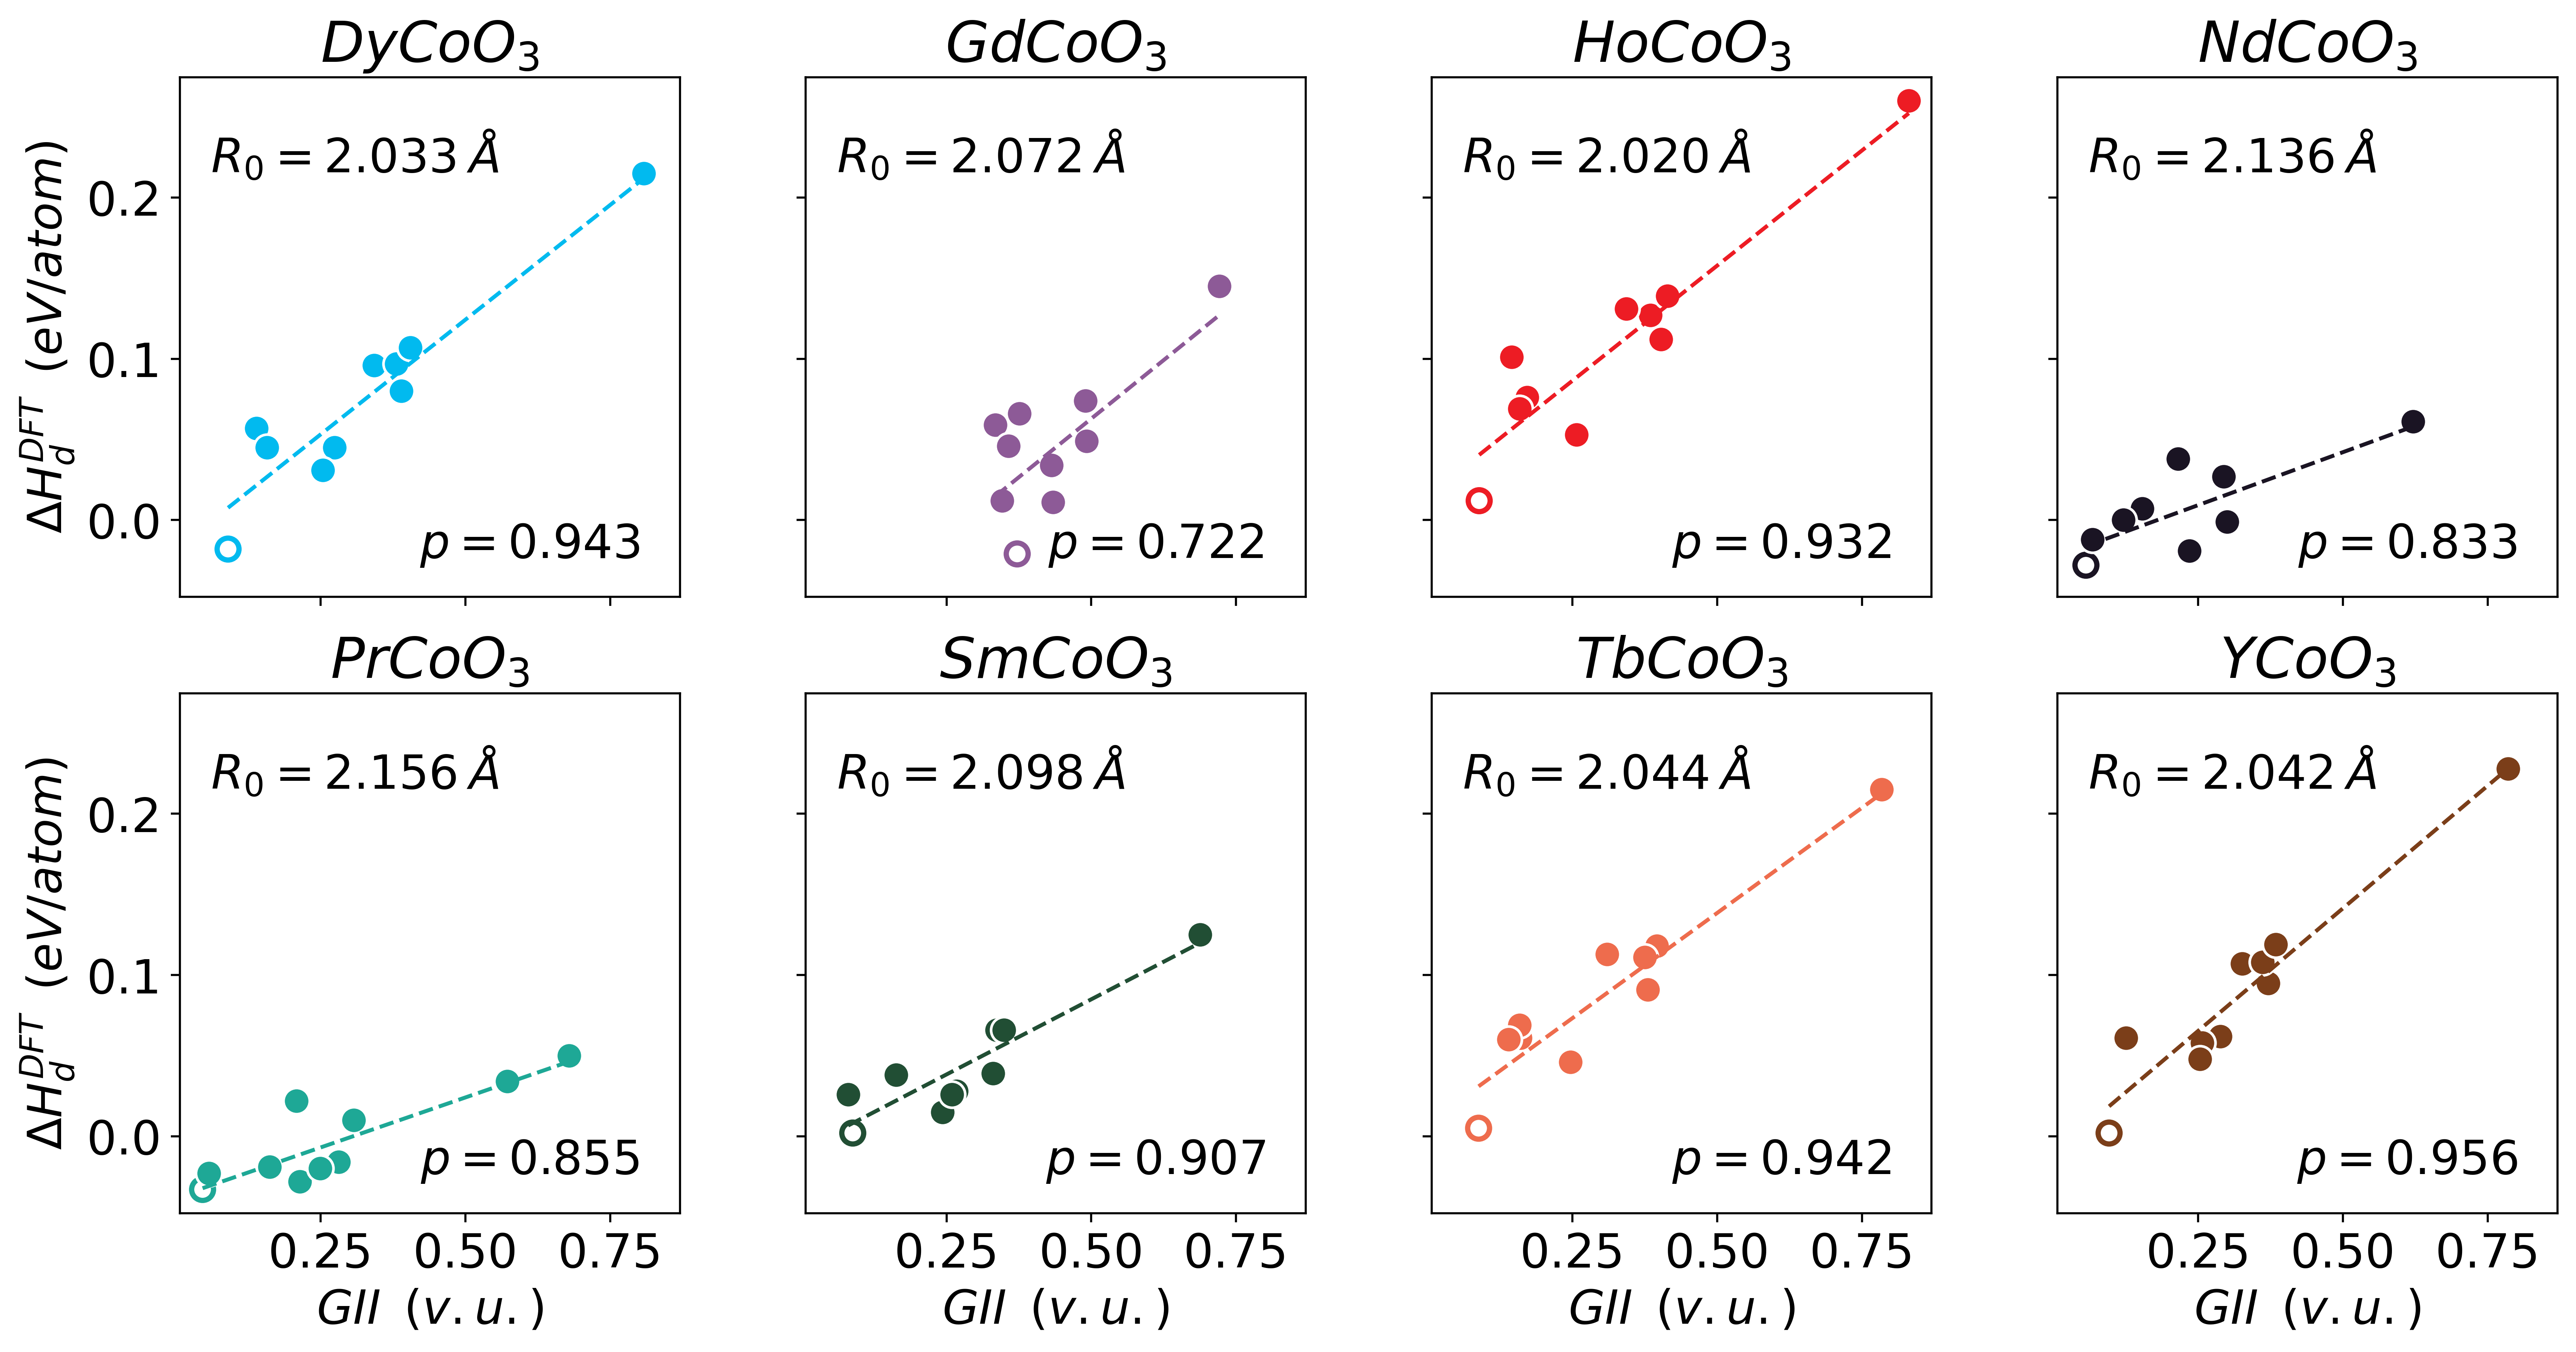

In [6]:
pair = (Specie('Co', 3), Specie('O', -2))
plot_by_species(pair, dct, g_08_params_dct, name='figures/general_GII_dHd.png')

## IQR Distribution Plotting

In [24]:
from visualization import periodic_table_heatmap_plot

In [25]:
def get_cations_and_counts(dct):
    all_cations = []
    for key in list(dct.keys()):
        s = dct[key]['structures'][0]
        cats = list(np.unique([c for c in s.species if np.sign(c.oxi_state) == 1]))
        all_cations += cats
    unique_cations, unique_counts = np.unique(all_cations, return_counts=True)
    return list(unique_cations), list(unique_counts)

In [26]:
cations, counts = get_cations_and_counts(dct)

51


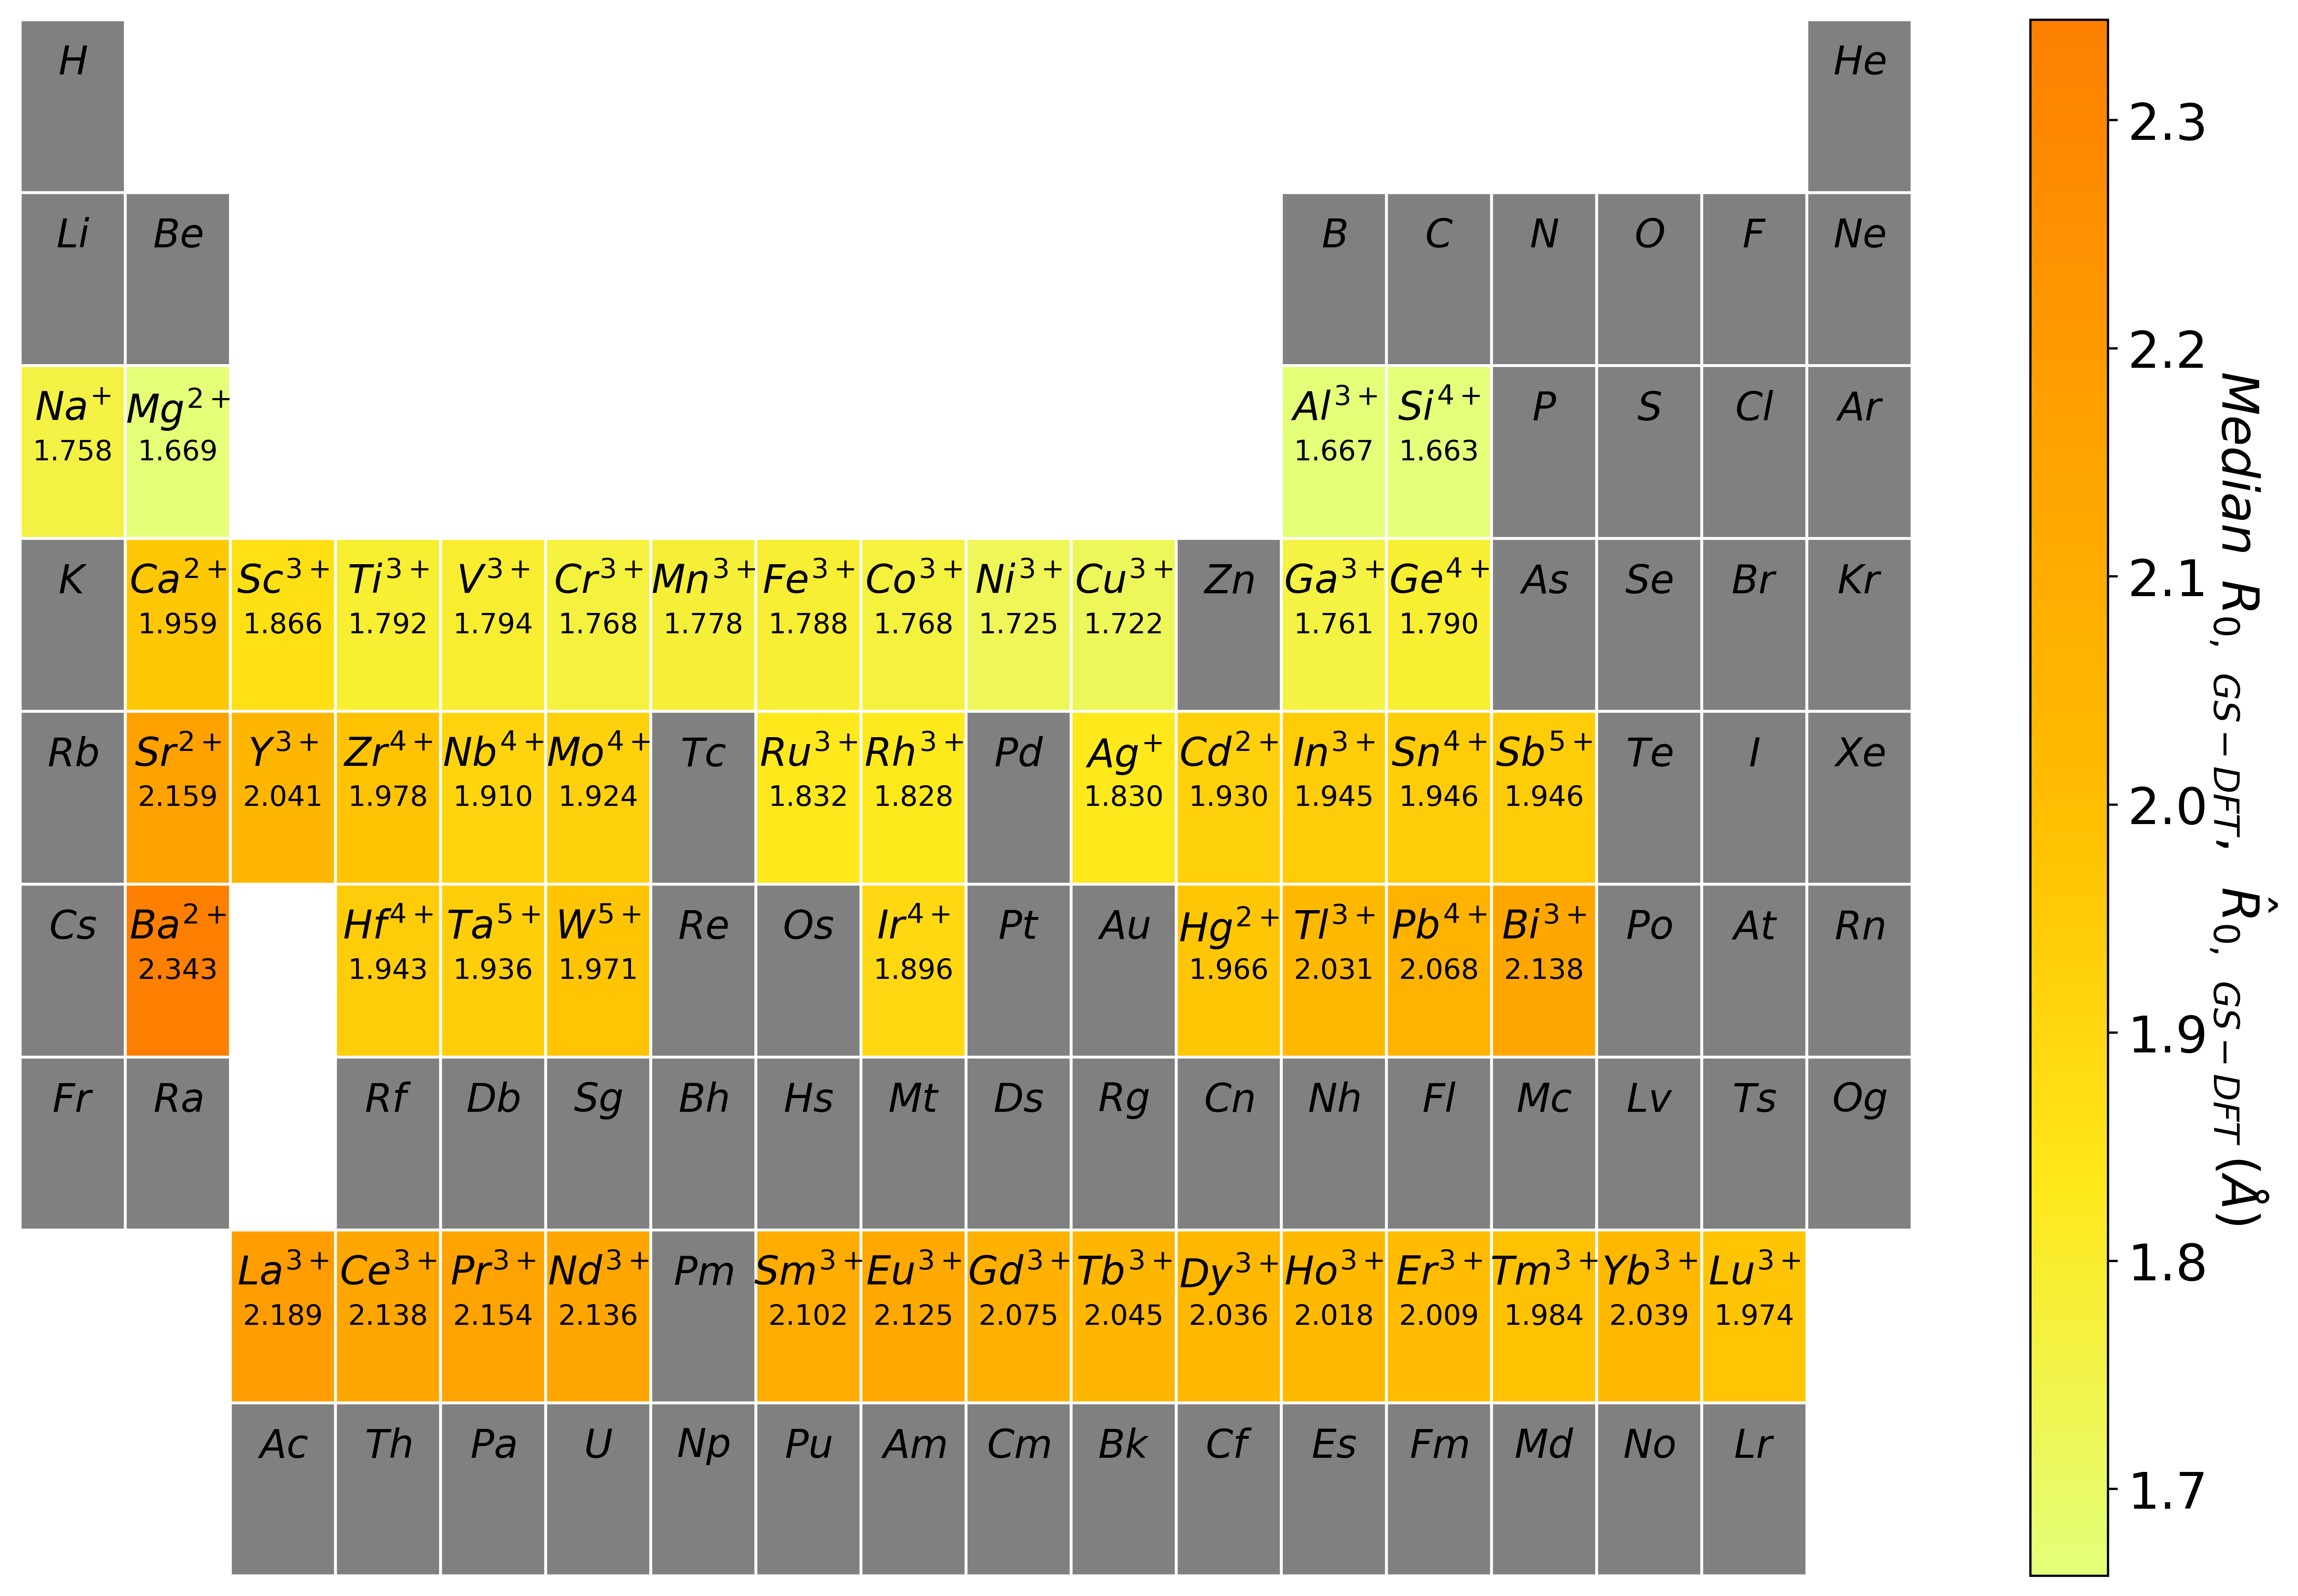

In [29]:
import warnings
warnings.filterwarnings("ignore")
used, meds = periodic_table_heatmap_plot(cations, counts, cs_065_params_dct, show='median', threshold=1,
                                         name='figures/composition_specific_median.png')

44


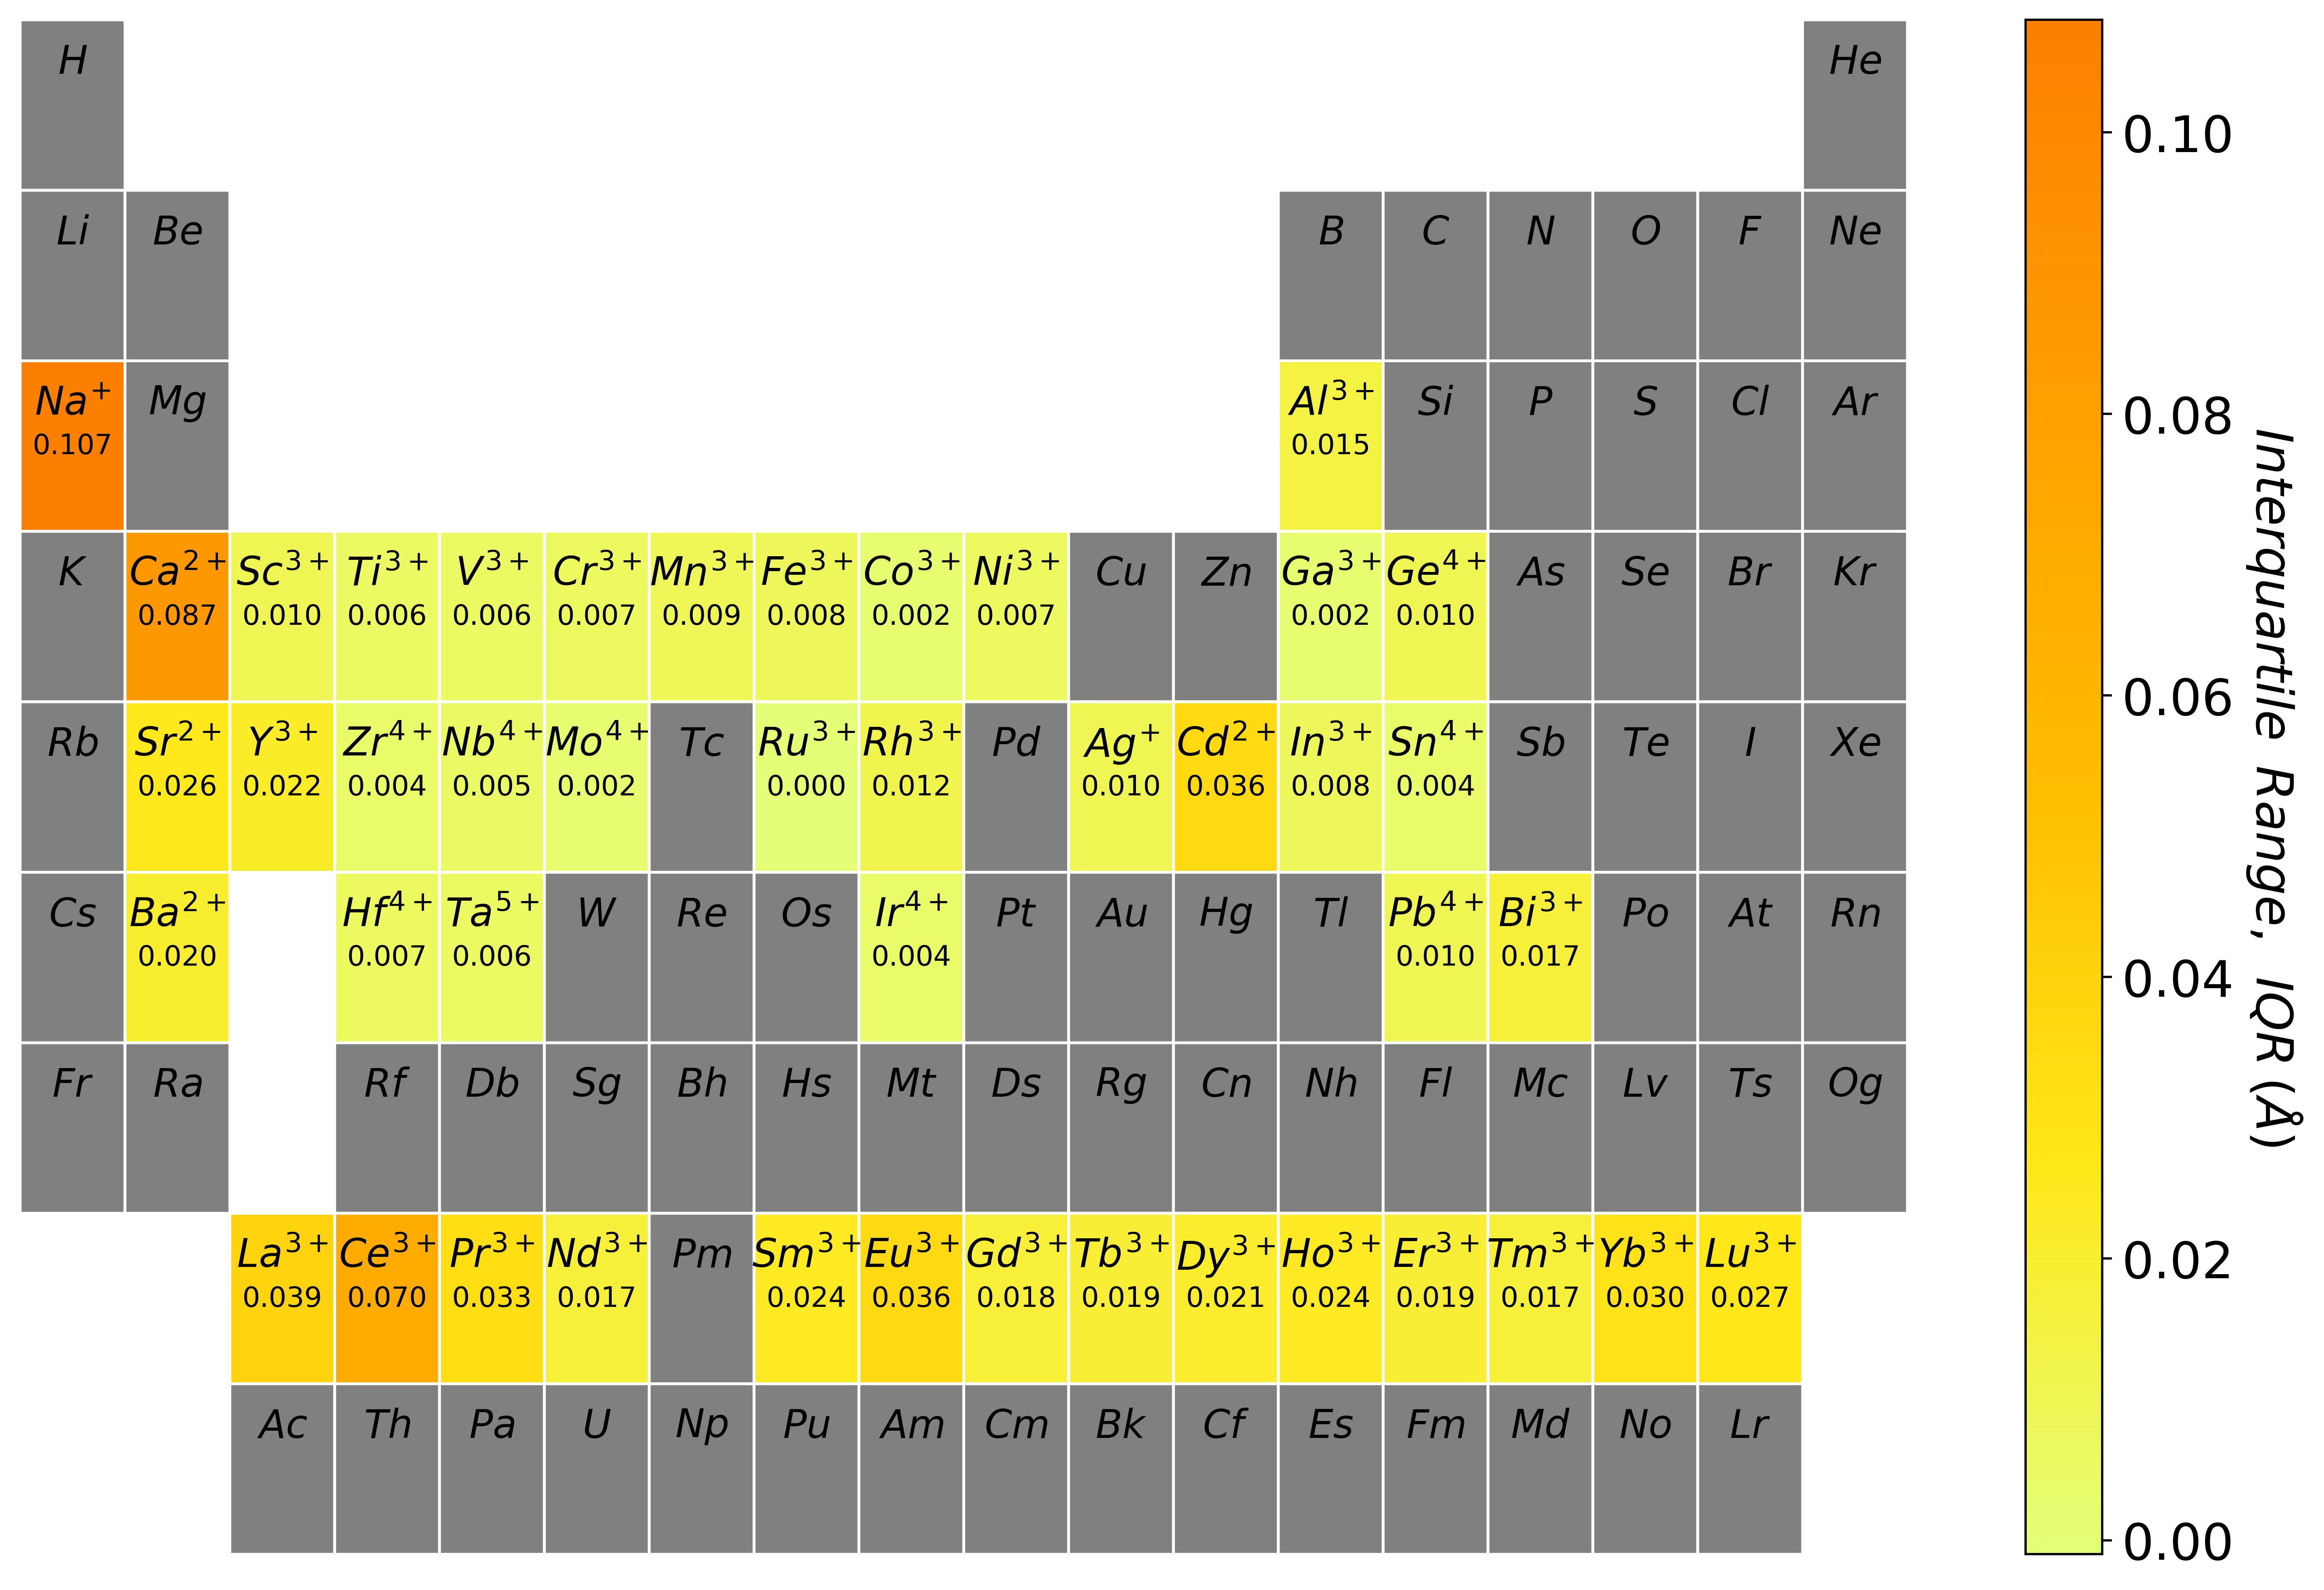

In [30]:
used, iqrs = periodic_table_heatmap_plot(cations, counts, cs_065_params_dct, show='IQR', name='figures/composition_specific_IQR.png')

## Energetics Analysis - Na+

In [8]:
#np.max(dct['NaTaO3']['energies'])-np.min(dct['NaTaO3']['energies'])

In [7]:
#na_pair = (Specie('Na', 1), Specie('O', -2))
#plot_by_species(na_pair, dct, cs_065_params_dct)

## CN Bond Distance Analysis - Ca2+, Ce3+, etc.

In [4]:
from analysis import bond_distances_by_coordination, range_bond_distance_by_coordination
from visualization import plot_broken_bar

In [5]:
ca_cation = Specie('Ca', 2)
dy_cation = Specie('Dy', 3)
ce_cation = Specie('Ce', 3)
la_cation = Specie('La', 3)
o_anion = Specie('O', -2)

In [6]:
ca_comp_coord_dct = bond_distances_by_coordination(ca_cation, o_anion, dct)
ca_coord_dct, ca_unique_coords, ca_counts = range_bond_distance_by_coordination(ca_comp_coord_dct)
dy_comp_coord_dct = bond_distances_by_coordination(dy_cation, o_anion, dct)
dy_coord_dct, dy_unique_coords, dy_counts = range_bond_distance_by_coordination(dy_comp_coord_dct)
ce_comp_coord_dct = bond_distances_by_coordination(ce_cation, o_anion, dct)
ce_coord_dct, ce_unique_coords, ce_counts = range_bond_distance_by_coordination(ce_comp_coord_dct)
la_comp_coord_dct = bond_distances_by_coordination(la_cation, o_anion, dct)
la_coord_dct, la_unique_coords, la_counts = range_bond_distance_by_coordination(la_comp_coord_dct)

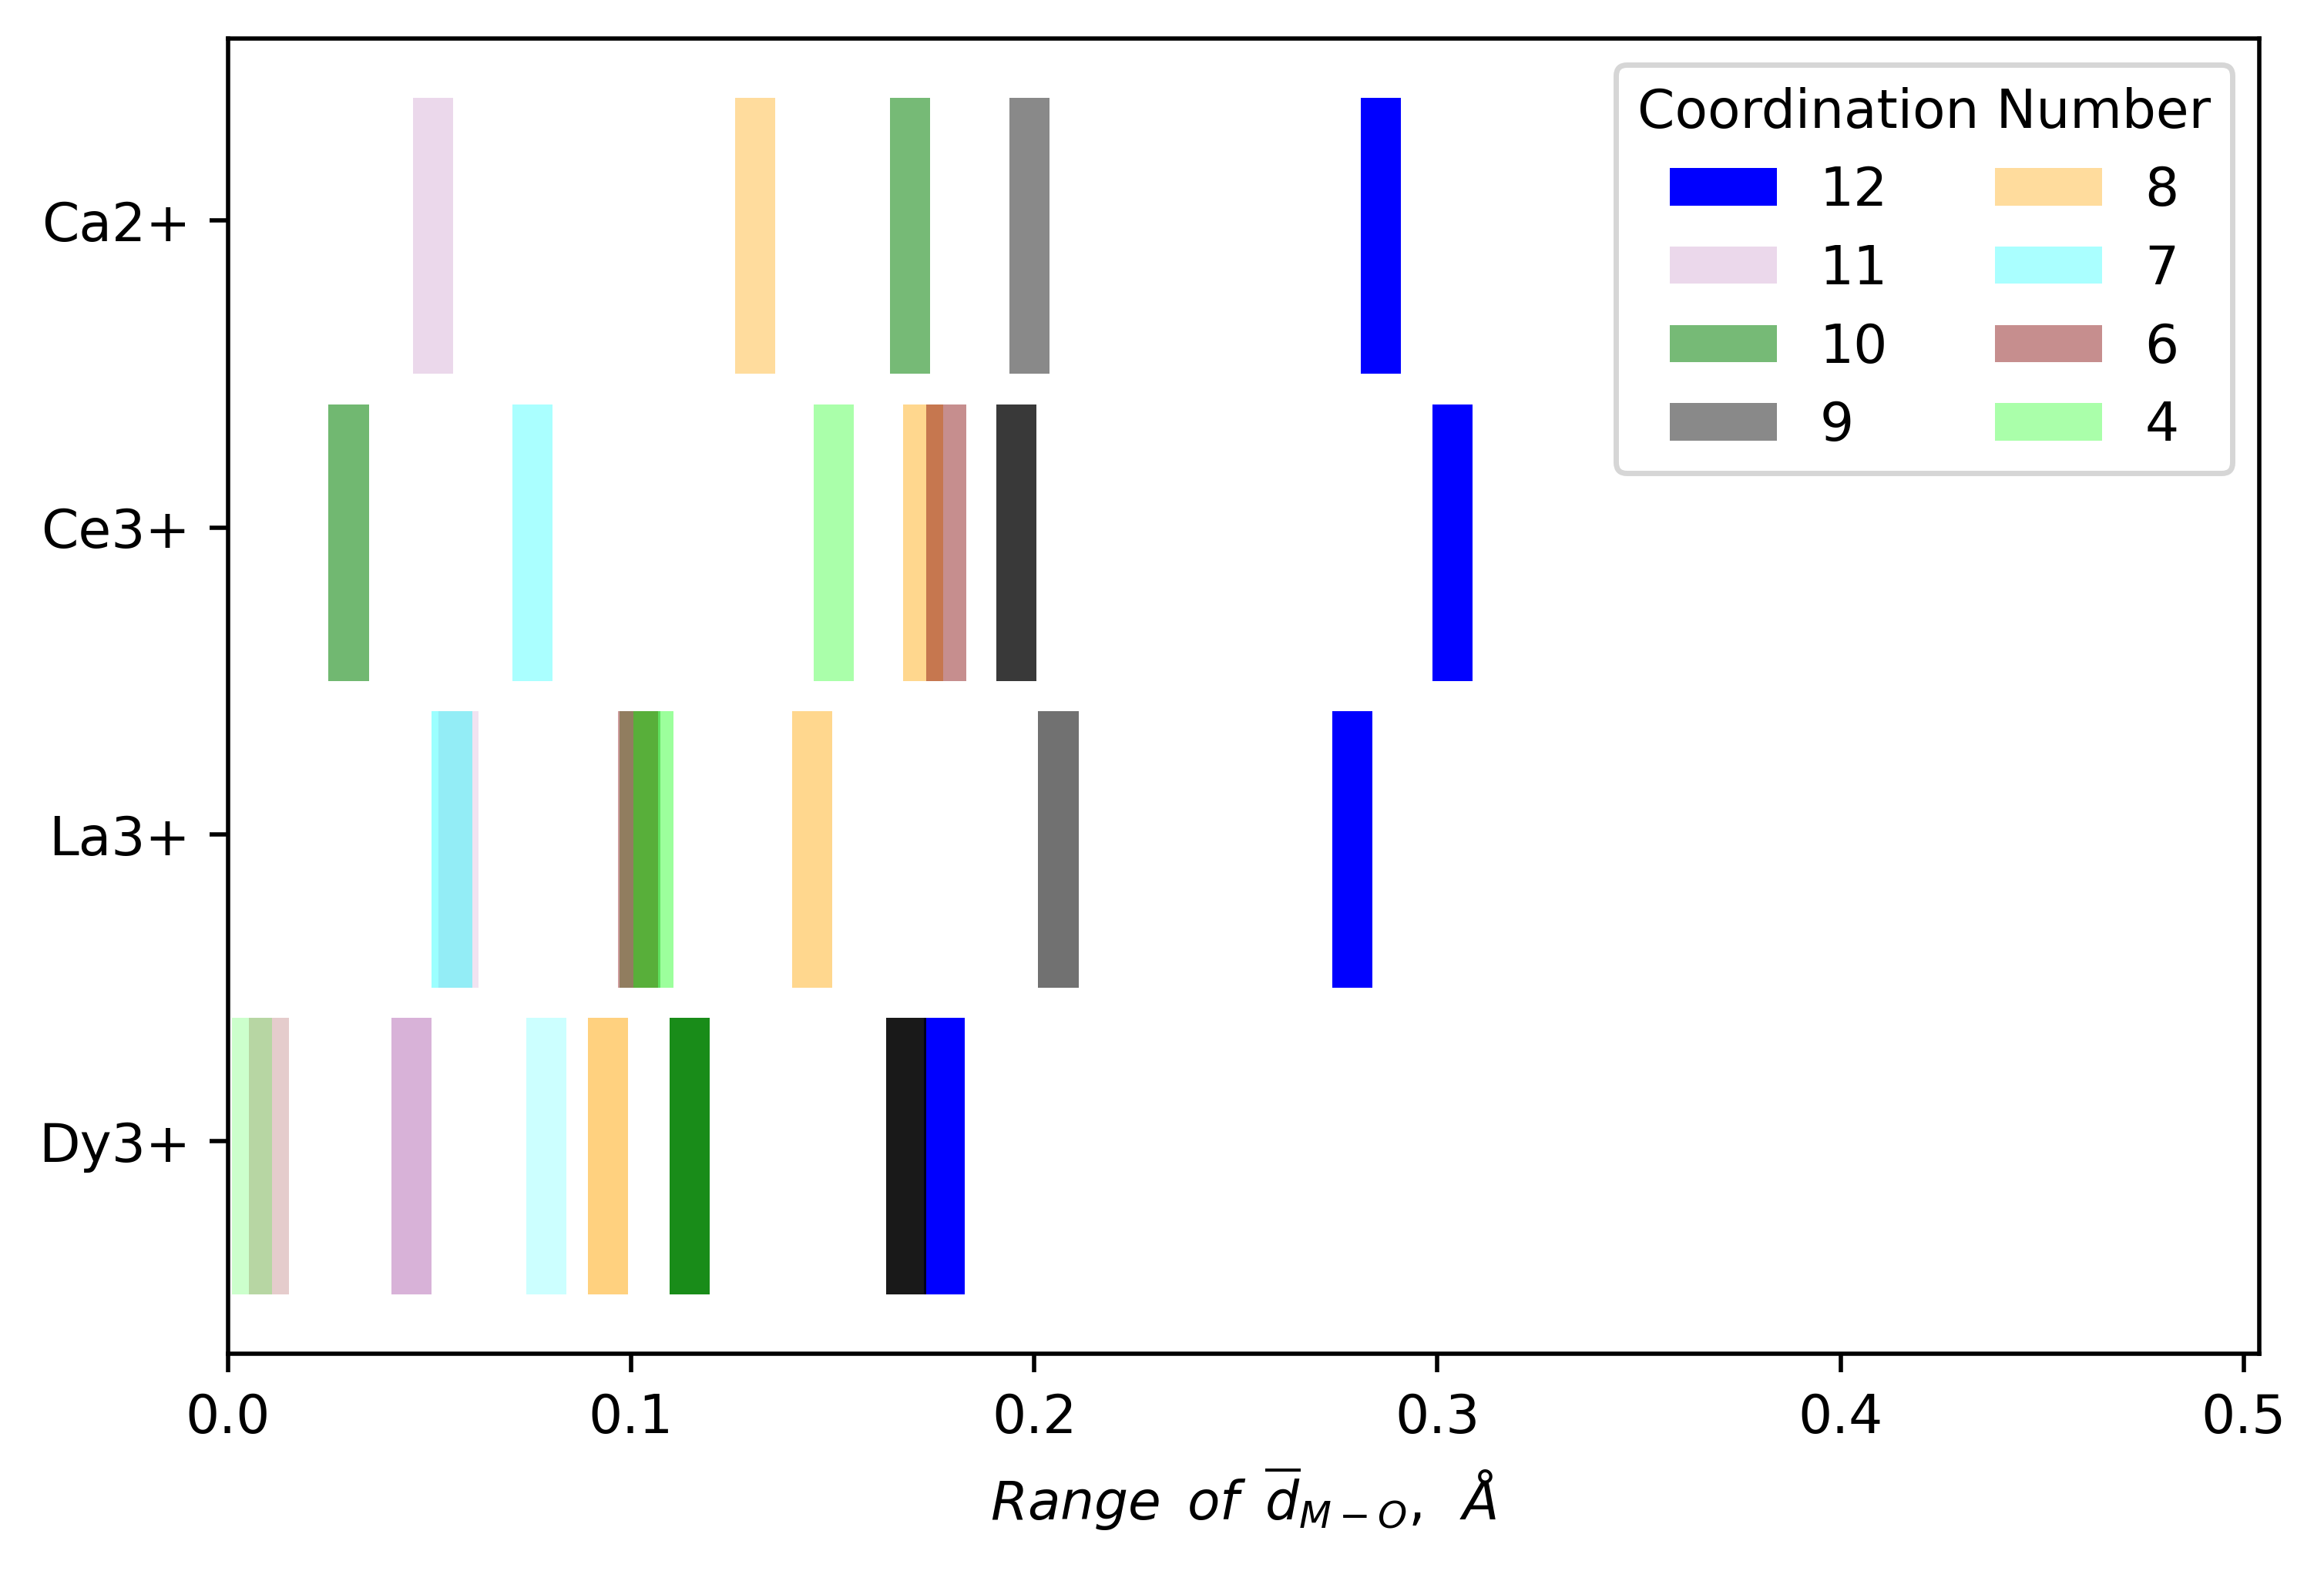

In [7]:
dcts_list = [dy_coord_dct, la_coord_dct, ce_coord_dct, ca_coord_dct]
cations_list = [Specie('Dy', 3), Specie('La', 3), Specie('Ce', 3), Specie('Ca', 2)]
unique_coords_list = [dy_unique_coords, la_unique_coords, ce_unique_coords, ca_unique_coords]
counts_list = [dy_counts, la_counts, ce_counts, ca_counts]
plot_broken_bar(dcts_list, cations_list, unique_coords_list, counts_list, name='figures/coordination_number_bond_distance.png')

## RMSD Stats

In [11]:
with open('optimized_parameters/59_g_11_tilts_rmsd_optimized_parameters.json') as json_file:
    g_rmsd_params_dct = json.load(json_file)

g_rmsd_params_dct['Cation'] = [Specie.from_dict(s) for s in g_rmsd_params_dct['Cation']]
g_rmsd_params_dct['Anion'] = [Specie.from_dict(s) for s in g_rmsd_params_dct['Anion']]

In [21]:
gs_giis_rmsd, pearsons_rmsd, correctly_ordered_rmsd, correctly_identified_gs_rmsd, cmpds_used_rmsd = stats(dct, 
                                                                                                           g_rmsd_params_dct)

  1%|▍                                                                                  | 1/188 [00:02<06:59,  2.24s/it]

AlBiO3 pearson -0.984


  2%|█▎                                                                                 | 3/188 [00:07<07:17,  2.36s/it]

BaPbO3 pearson -0.176


  2%|█▊                                                                                 | 4/188 [00:09<07:04,  2.31s/it]

CaCrO3 pearson -0.227


  3%|██▏                                                                                | 5/188 [00:11<07:08,  2.34s/it]

CaGeO3 pearson 0.085


  4%|███                                                                                | 7/188 [00:15<06:43,  2.23s/it]

CaIrO3 pearson 0.533


  4%|███▌                                                                               | 8/188 [00:18<07:02,  2.35s/it]

CaMnO3 pearson -0.064


  6%|█████▏                                                                            | 12/188 [00:27<06:22,  2.17s/it]

CaRuO3 pearson 0.656


  8%|██████▌                                                                           | 15/188 [00:33<06:25,  2.23s/it]

CaVO3 pearson 0.462


  9%|███████▍                                                                          | 17/188 [00:38<06:25,  2.26s/it]

CdGeO3 pearson 0.307


 10%|████████▎                                                                         | 19/188 [00:42<06:15,  2.22s/it]

CeAlO3 pearson -0.831


 11%|████████▋                                                                         | 20/188 [00:44<06:19,  2.26s/it]

CeCrO3 pearson 0.342


 11%|█████████▏                                                                        | 21/188 [00:46<06:04,  2.18s/it]

CeFeO3 pearson -0.514


 14%|███████████▎                                                                      | 26/188 [00:57<05:35,  2.07s/it]

CeVO3 pearson 0.017


 14%|███████████▊                                                                      | 27/188 [00:59<05:46,  2.15s/it]

DyAlO3 pearson -0.492


 15%|████████████▏                                                                     | 28/188 [01:01<05:50,  2.19s/it]

DyCoO3 pearson 0.162


 15%|████████████▋                                                                     | 29/188 [01:03<05:49,  2.20s/it]

DyCrO3 pearson 0.542


 16%|█████████████                                                                     | 30/188 [01:06<05:41,  2.16s/it]

DyFeO3 pearson 0.674


 16%|█████████████▌                                                                    | 31/188 [01:08<05:36,  2.14s/it]

DyMnO3 pearson 0.532


 17%|█████████████▉                                                                    | 32/188 [01:10<05:40,  2.18s/it]

DyNiO3 pearson 0.049


 20%|████████████████▏                                                                 | 37/188 [01:20<05:21,  2.13s/it]

ErAlO3 pearson 0.162


 22%|█████████████████▉                                                                | 41/188 [01:29<05:10,  2.11s/it]

ErNiO3 pearson 0.392


 24%|███████████████████▋                                                              | 45/188 [01:37<05:02,  2.11s/it]

EuAlO3 pearson -0.958


 24%|████████████████████                                                              | 46/188 [01:39<05:04,  2.15s/it]

EuCrO3 pearson 0.605


 26%|████████████████████▉                                                             | 48/188 [01:44<05:07,  2.20s/it]

EuGaO3 pearson 0.55


 27%|█████████████████████▊                                                            | 50/188 [01:48<05:11,  2.26s/it]

EuNiO3 pearson -0.473


 29%|███████████████████████▌                                                          | 54/188 [01:57<04:51,  2.18s/it]

FeBiO3 pearson 0.254


 29%|███████████████████████▉                                                          | 55/188 [01:59<04:57,  2.24s/it]

GdAlO3 pearson -0.585


 30%|████████████████████████▍                                                         | 56/188 [02:01<04:56,  2.24s/it]

GdCoO3 pearson -0.047


 32%|██████████████████████████▏                                                       | 60/188 [02:10<04:37,  2.17s/it]

GdMnO3 pearson 0.696


 32%|██████████████████████████▌                                                       | 61/188 [02:12<04:36,  2.18s/it]

GdNiO3 pearson 0.115


 36%|█████████████████████████████▏                                                    | 67/188 [02:25<04:27,  2.21s/it]

HoAlO3 pearson 0.052


 36%|█████████████████████████████▋                                                    | 68/188 [02:27<04:23,  2.20s/it]

HoCoO3 pearson 0.314


 38%|███████████████████████████████▍                                                  | 72/188 [02:36<04:08,  2.14s/it]

HoNiO3 pearson 0.412


 41%|█████████████████████████████████▌                                                | 77/188 [02:45<03:47,  2.05s/it]

LaCrO3 pearson -0.432


 41%|██████████████████████████████████                                                | 78/188 [02:48<03:55,  2.14s/it]

LaCuO3 pearson -0.919


 43%|██████████████████████████████████▉                                               | 80/188 [02:52<03:43,  2.07s/it]

LaFeO3 pearson 0.339


 43%|███████████████████████████████████▎                                              | 81/188 [02:56<04:49,  2.70s/it]

LaGaO3 pearson -0.294


 45%|█████████████████████████████████████                                             | 85/188 [03:04<03:41,  2.15s/it]

LaMnO3 pearson 0.088


 46%|█████████████████████████████████████▌                                            | 86/188 [03:06<03:41,  2.17s/it]

LaNiO3 pearson -0.983


 46%|█████████████████████████████████████▉                                            | 87/188 [03:08<03:37,  2.15s/it]

LaRhO3 pearson 0.215


 47%|██████████████████████████████████████▍                                           | 88/188 [03:10<03:35,  2.15s/it]

LaRuO3 pearson 0.462


 48%|███████████████████████████████████████▎                                          | 90/188 [03:14<03:34,  2.19s/it]

LaTiO3 pearson 0.629


 49%|████████████████████████████████████████▏                                         | 92/188 [03:19<03:27,  2.16s/it]

LaVO3 pearson 0.486


 52%|██████████████████████████████████████████▋                                       | 98/188 [03:30<02:58,  1.98s/it]

LuTiO3 min_gii 0.209


 53%|███████████████████████████████████████████▏                                      | 99/188 [03:32<03:04,  2.07s/it]

MgSiO3 pearson 0.66


 53%|███████████████████████████████████████████                                      | 100/188 [03:35<03:06,  2.12s/it]

MnBiO3 pearson 0.023


 54%|███████████████████████████████████████████▉                                     | 102/188 [03:39<03:12,  2.24s/it]

NaSbO3 pearson 0.576


 55%|████████████████████████████████████████████▊                                    | 104/188 [03:44<03:13,  2.30s/it]

NaWO3 pearson 0.096


 56%|█████████████████████████████████████████████▏                                   | 105/188 [03:46<03:12,  2.32s/it]

NbAgO3 pearson 0.595


 56%|█████████████████████████████████████████████▋                                   | 106/188 [03:49<03:08,  2.30s/it]

NdAlO3 pearson -0.993


 57%|██████████████████████████████████████████████                                   | 107/188 [03:51<03:02,  2.26s/it]

NdCoO3 pearson 0.075


 57%|██████████████████████████████████████████████▌                                  | 108/188 [03:53<02:59,  2.24s/it]

NdCrO3 pearson 0.319


 58%|██████████████████████████████████████████████▉                                  | 109/188 [03:55<02:55,  2.23s/it]

NdFeO3 pearson 0.646


 59%|███████████████████████████████████████████████▍                                 | 110/188 [03:57<02:53,  2.22s/it]

NdGaO3 pearson 0.487


 60%|████████████████████████████████████████████████▎                                | 112/188 [04:01<02:41,  2.13s/it]

NdMnO3 pearson 0.426


 60%|████████████████████████████████████████████████▋                                | 113/188 [04:04<02:44,  2.19s/it]

NdNiO3 pearson -0.665


 61%|█████████████████████████████████████████████████                                | 114/188 [04:06<02:40,  2.17s/it]

NdRhO3 pearson 0.576


 62%|█████████████████████████████████████████████████▉                               | 116/188 [04:10<02:33,  2.14s/it]

NdTiO3 pearson 0.686


 62%|██████████████████████████████████████████████████▍                              | 117/188 [04:12<02:33,  2.16s/it]

NdVO3 pearson 0.633


 63%|██████████████████████████████████████████████████▊                              | 118/188 [04:14<02:32,  2.18s/it]

PrAlO3 pearson -0.998


 63%|███████████████████████████████████████████████████▎                             | 119/188 [04:17<02:33,  2.22s/it]

PrCoO3 pearson 0.249


 64%|███████████████████████████████████████████████████▋                             | 120/188 [04:19<02:30,  2.22s/it]

PrCrO3 pearson 0.203


 64%|████████████████████████████████████████████████████▏                            | 121/188 [04:21<02:28,  2.21s/it]

PrFeO3 pearson 0.598


 65%|████████████████████████████████████████████████████▌                            | 122/188 [04:23<02:26,  2.21s/it]

PrGaO3 pearson 0.409


 66%|█████████████████████████████████████████████████████▍                           | 124/188 [04:27<02:16,  2.14s/it]

PrMnO3 pearson 0.439


 66%|█████████████████████████████████████████████████████▊                           | 125/188 [04:30<02:18,  2.19s/it]

PrNiO3 pearson -0.853


 67%|██████████████████████████████████████████████████████▎                          | 126/188 [04:32<02:17,  2.21s/it]

PrRhO3 pearson 0.507


 68%|██████████████████████████████████████████████████████▋                          | 127/188 [04:34<02:14,  2.21s/it]

PrRuO3 pearson 0.585


 69%|███████████████████████████████████████████████████████▌                         | 129/188 [04:39<02:08,  2.19s/it]

PrTiO3 pearson 0.659


 69%|████████████████████████████████████████████████████████                         | 130/188 [04:41<02:07,  2.19s/it]

PrVO3 pearson 0.613


 71%|█████████████████████████████████████████████████████████▎                       | 133/188 [04:47<01:52,  2.05s/it]

ScCrO3 min_gii 0.258


 71%|█████████████████████████████████████████████████████████▋                       | 134/188 [04:49<01:54,  2.13s/it]

SmAlO3 pearson -0.961


 72%|██████████████████████████████████████████████████████████▏                      | 135/188 [04:52<01:57,  2.23s/it]

SmCoO3 pearson 0.023


 72%|██████████████████████████████████████████████████████████▌                      | 136/188 [04:54<01:56,  2.25s/it]

SmCrO3 pearson 0.437


 73%|███████████████████████████████████████████████████████████                      | 137/188 [04:56<01:53,  2.22s/it]

SmFeO3 pearson 0.64


 74%|███████████████████████████████████████████████████████████▉                     | 139/188 [05:00<01:44,  2.12s/it]

SmMnO3 pearson 0.427


 74%|████████████████████████████████████████████████████████████▎                    | 140/188 [05:02<01:43,  2.15s/it]

SmNiO3 pearson -0.324


 75%|████████████████████████████████████████████████████████████▊                    | 141/188 [05:04<01:39,  2.12s/it]

SmRhO3 pearson 0.646


 77%|██████████████████████████████████████████████████████████████                   | 144/188 [05:11<01:33,  2.12s/it]

SmVO3 pearson 0.659


 78%|███████████████████████████████████████████████████████████████▎                 | 147/188 [05:17<01:30,  2.21s/it]

SrIrO3 pearson -0.898


 79%|███████████████████████████████████████████████████████████████▊                 | 148/188 [05:20<01:32,  2.31s/it]

SrMoO3 pearson 0.627


 80%|█████████████████████████████████████████████████████████████████                | 151/188 [05:26<01:21,  2.20s/it]

SrRuO3 pearson -0.973


 82%|██████████████████████████████████████████████████████████████████▎              | 154/188 [05:35<01:27,  2.57s/it]

TaAgO3 pearson 0.697


 82%|██████████████████████████████████████████████████████████████████▊              | 155/188 [05:37<01:22,  2.49s/it]

TbAlO3 pearson -0.562


 83%|███████████████████████████████████████████████████████████████████▏             | 156/188 [05:39<01:16,  2.40s/it]

TbCoO3 pearson 0.132


 84%|███████████████████████████████████████████████████████████████████▋             | 157/188 [05:42<01:13,  2.37s/it]

TbCrO3 pearson 0.577


 84%|████████████████████████████████████████████████████████████████████             | 158/188 [05:44<01:09,  2.32s/it]

TbFeO3 pearson 0.685


 85%|████████████████████████████████████████████████████████████████████▌            | 159/188 [05:46<01:05,  2.27s/it]

TbMnO3 pearson 0.605


 87%|██████████████████████████████████████████████████████████████████████▋          | 164/188 [05:57<00:53,  2.23s/it]

TlNiO3 pearson 0.669


 90%|████████████████████████████████████████████████████████████████████████▊        | 169/188 [06:08<00:40,  2.14s/it]

TmTiO3 min_gii 0.205


 90%|█████████████████████████████████████████████████████████████████████████▏       | 170/188 [06:10<00:39,  2.18s/it]

YAlO3 pearson -0.068


 91%|█████████████████████████████████████████████████████████████████████████▋       | 171/188 [06:12<00:37,  2.18s/it]

YCoO3 pearson 0.253


 94%|███████████████████████████████████████████████████████████████████████████▊     | 176/188 [06:23<00:26,  2.20s/it]

YNiO3 pearson 0.296


 96%|█████████████████████████████████████████████████████████████████████████████▌   | 180/188 [06:32<00:17,  2.18s/it]

YbAlO3 pearson -0.223


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 181/188 [06:33<00:14,  2.05s/it]

YbCeO3 min_gii 0.443


 97%|██████████████████████████████████████████████████████████████████████████████▊  | 183/188 [06:38<00:10,  2.18s/it]

YbFeO3 min_gii 0.262


 98%|███████████████████████████████████████████████████████████████████████████████▎ | 184/188 [06:40<00:08,  2.21s/it]

YbMnO3 min_gii 0.284


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [06:49<00:00,  2.18s/it]


In [22]:
print_stats(gs_giis_rmsd, pearsons_rmsd, correctly_ordered_rmsd, correctly_identified_gs_rmsd)

Number of gii_gs <= 0.1: 122/188
Number of ground states correctly identified by GII: 41
Minimum Pearson: -0.993
N >= 8: 54


## Compare R0 Parameters

In [16]:
from visualization import compare_rmsd_to_gs_dft_R0
from analysis import stats

Alkali metal 1 0.023
Alkaline earth metal 4 0.03
Lanthanide 15 0.028
Metalloid 3 -0.009
Post-transition metal 8 -0.008
Transition metal 28 -0.021


<Figure size 432x288 with 0 Axes>

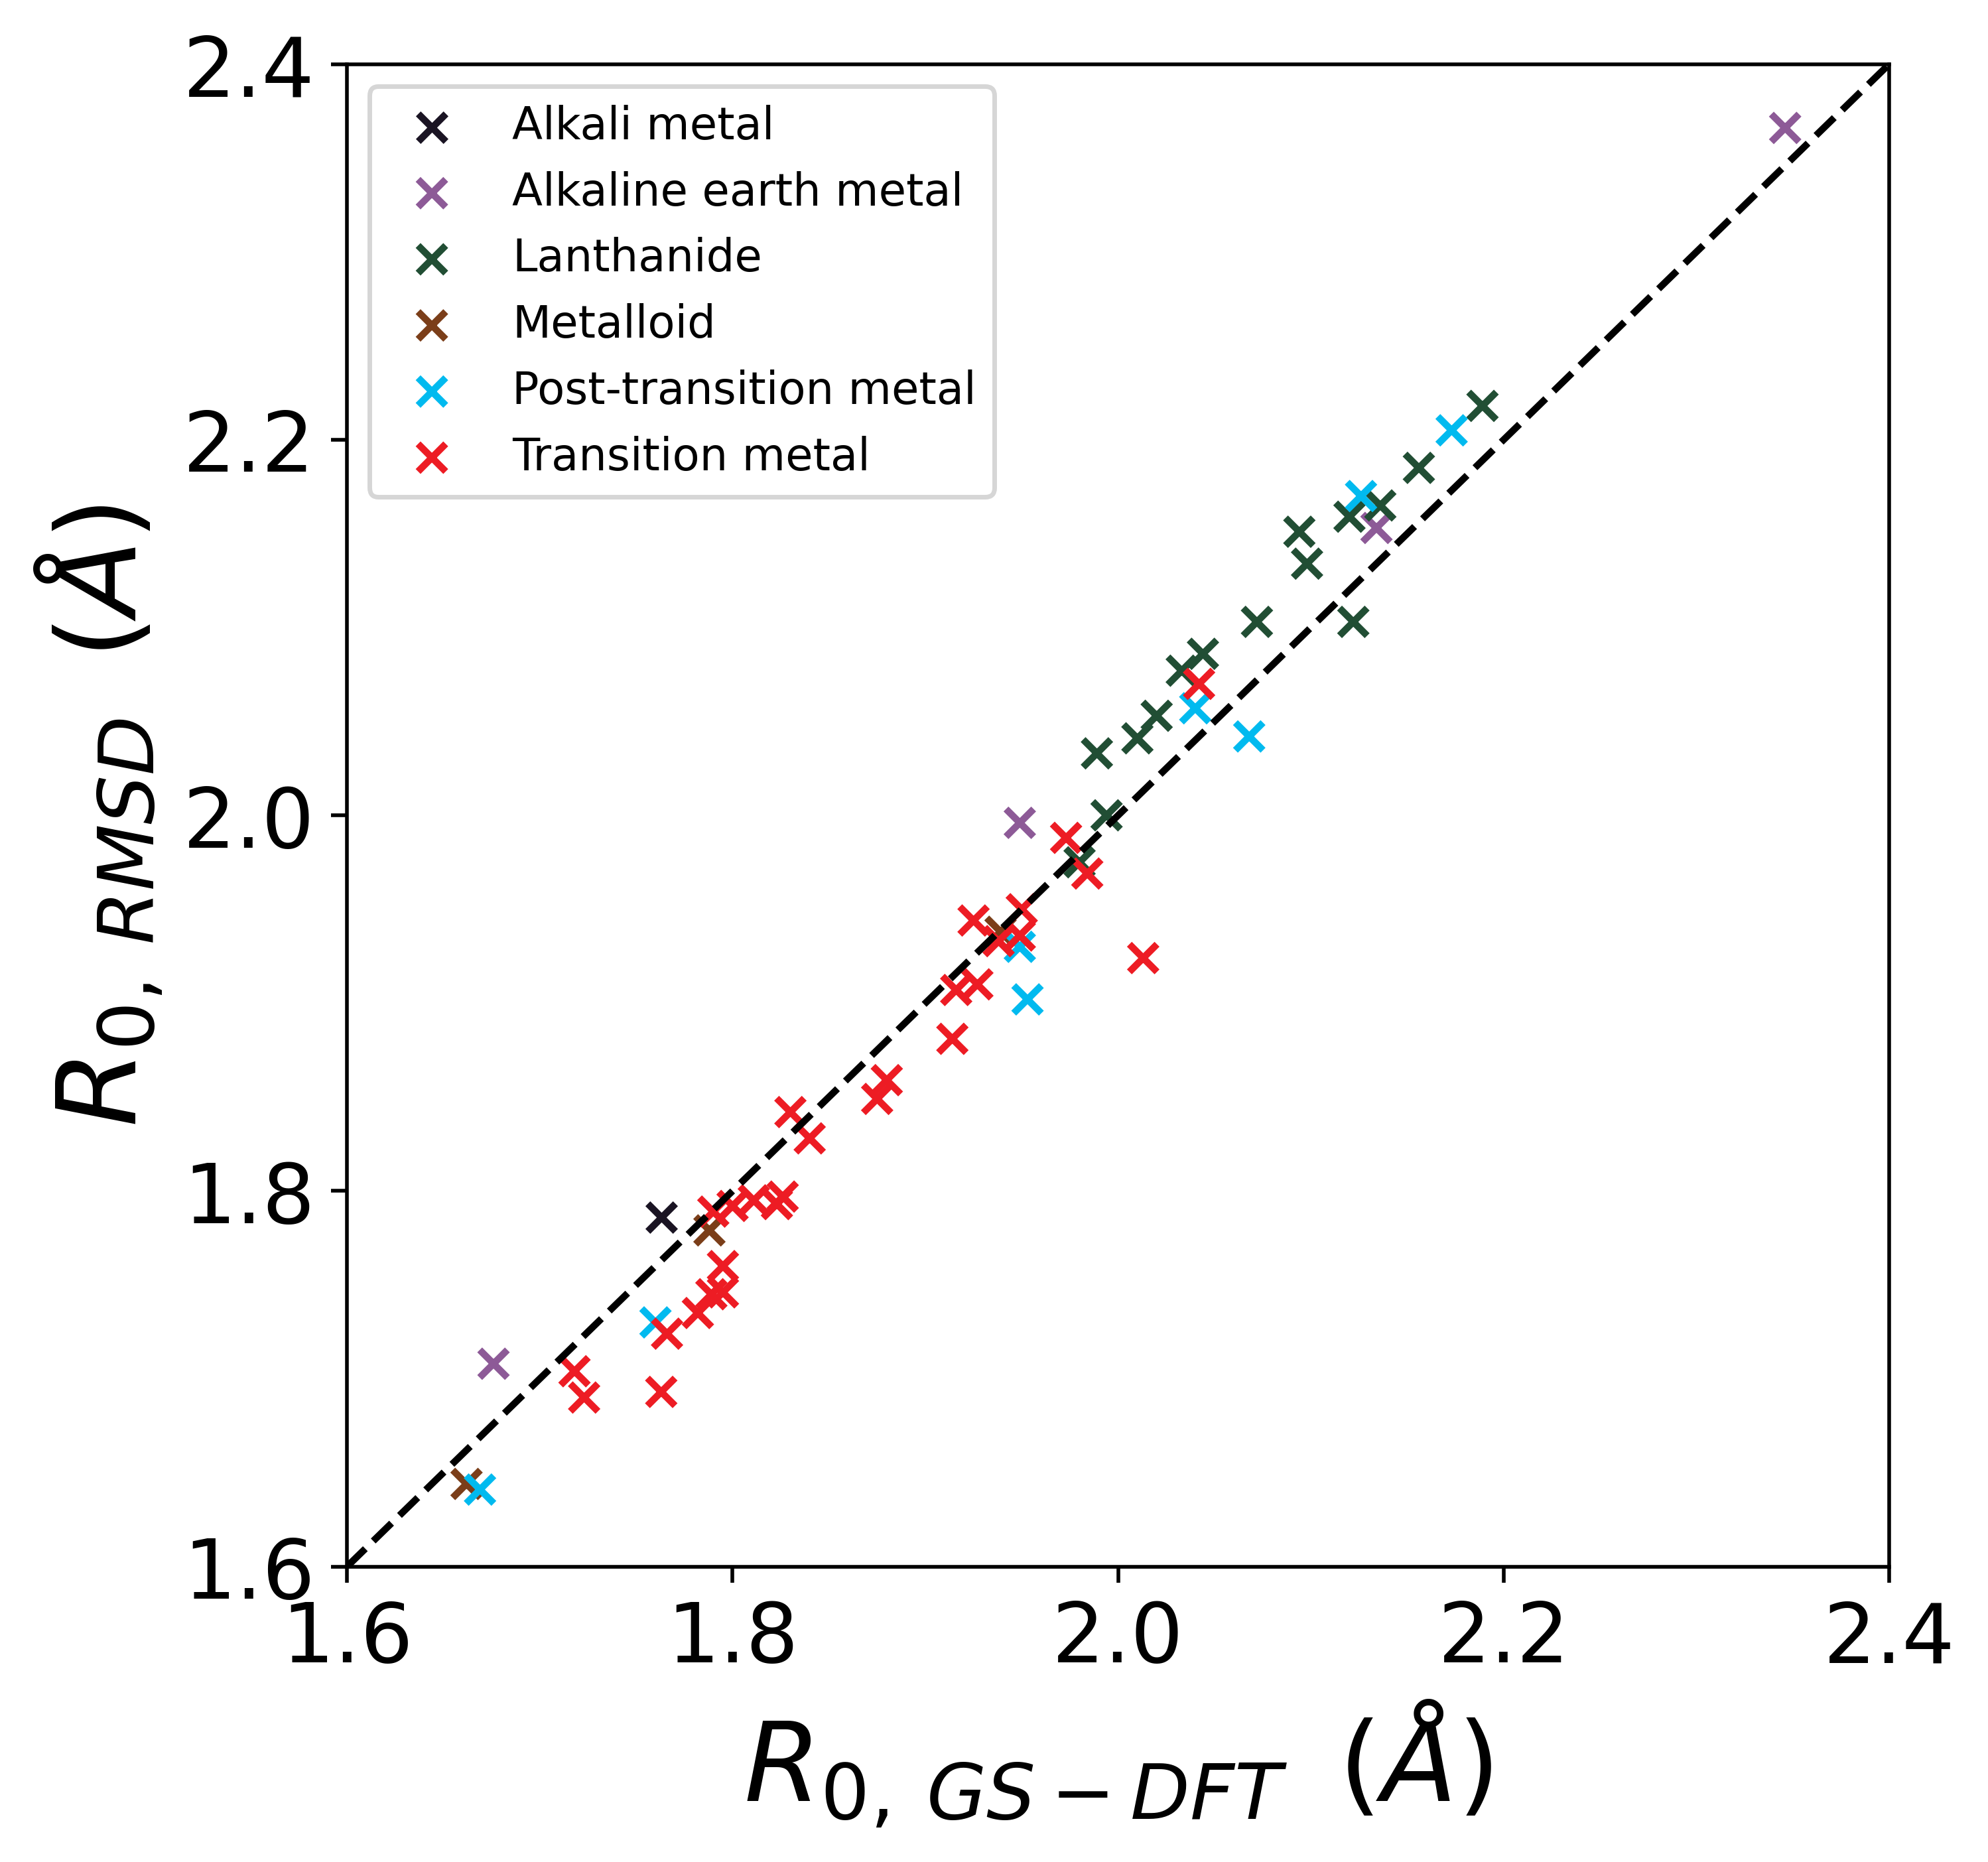

In [32]:
compare_rmsd_to_gs_dft_R0(g_rmsd_params_dct, g_08_params_dct, name='figures/compare_R0_parameters.png')

## Compare the tbv of RMSD to GS DFT

In [33]:
from visualization import compare_tbvs

In [15]:
with open('tbv_compositions/188_compositions_with_sites_designated.json') as f:
    tbv_dct = json.load(f)

In [16]:
for cmpd in list(tbv_dct.keys()):
    tbv_dct[cmpd]['A_sites'] = [Specie.from_dict(a) for a in tbv_dct[cmpd]['A_sites']]
    tbv_dct[cmpd]['B_sites'] = [Specie.from_dict(b) for b in tbv_dct[cmpd]['B_sites']]
    tbv_dct[cmpd]['X_sites'] = [Specie.from_dict(x) for x in tbv_dct[cmpd]['X_sites']]

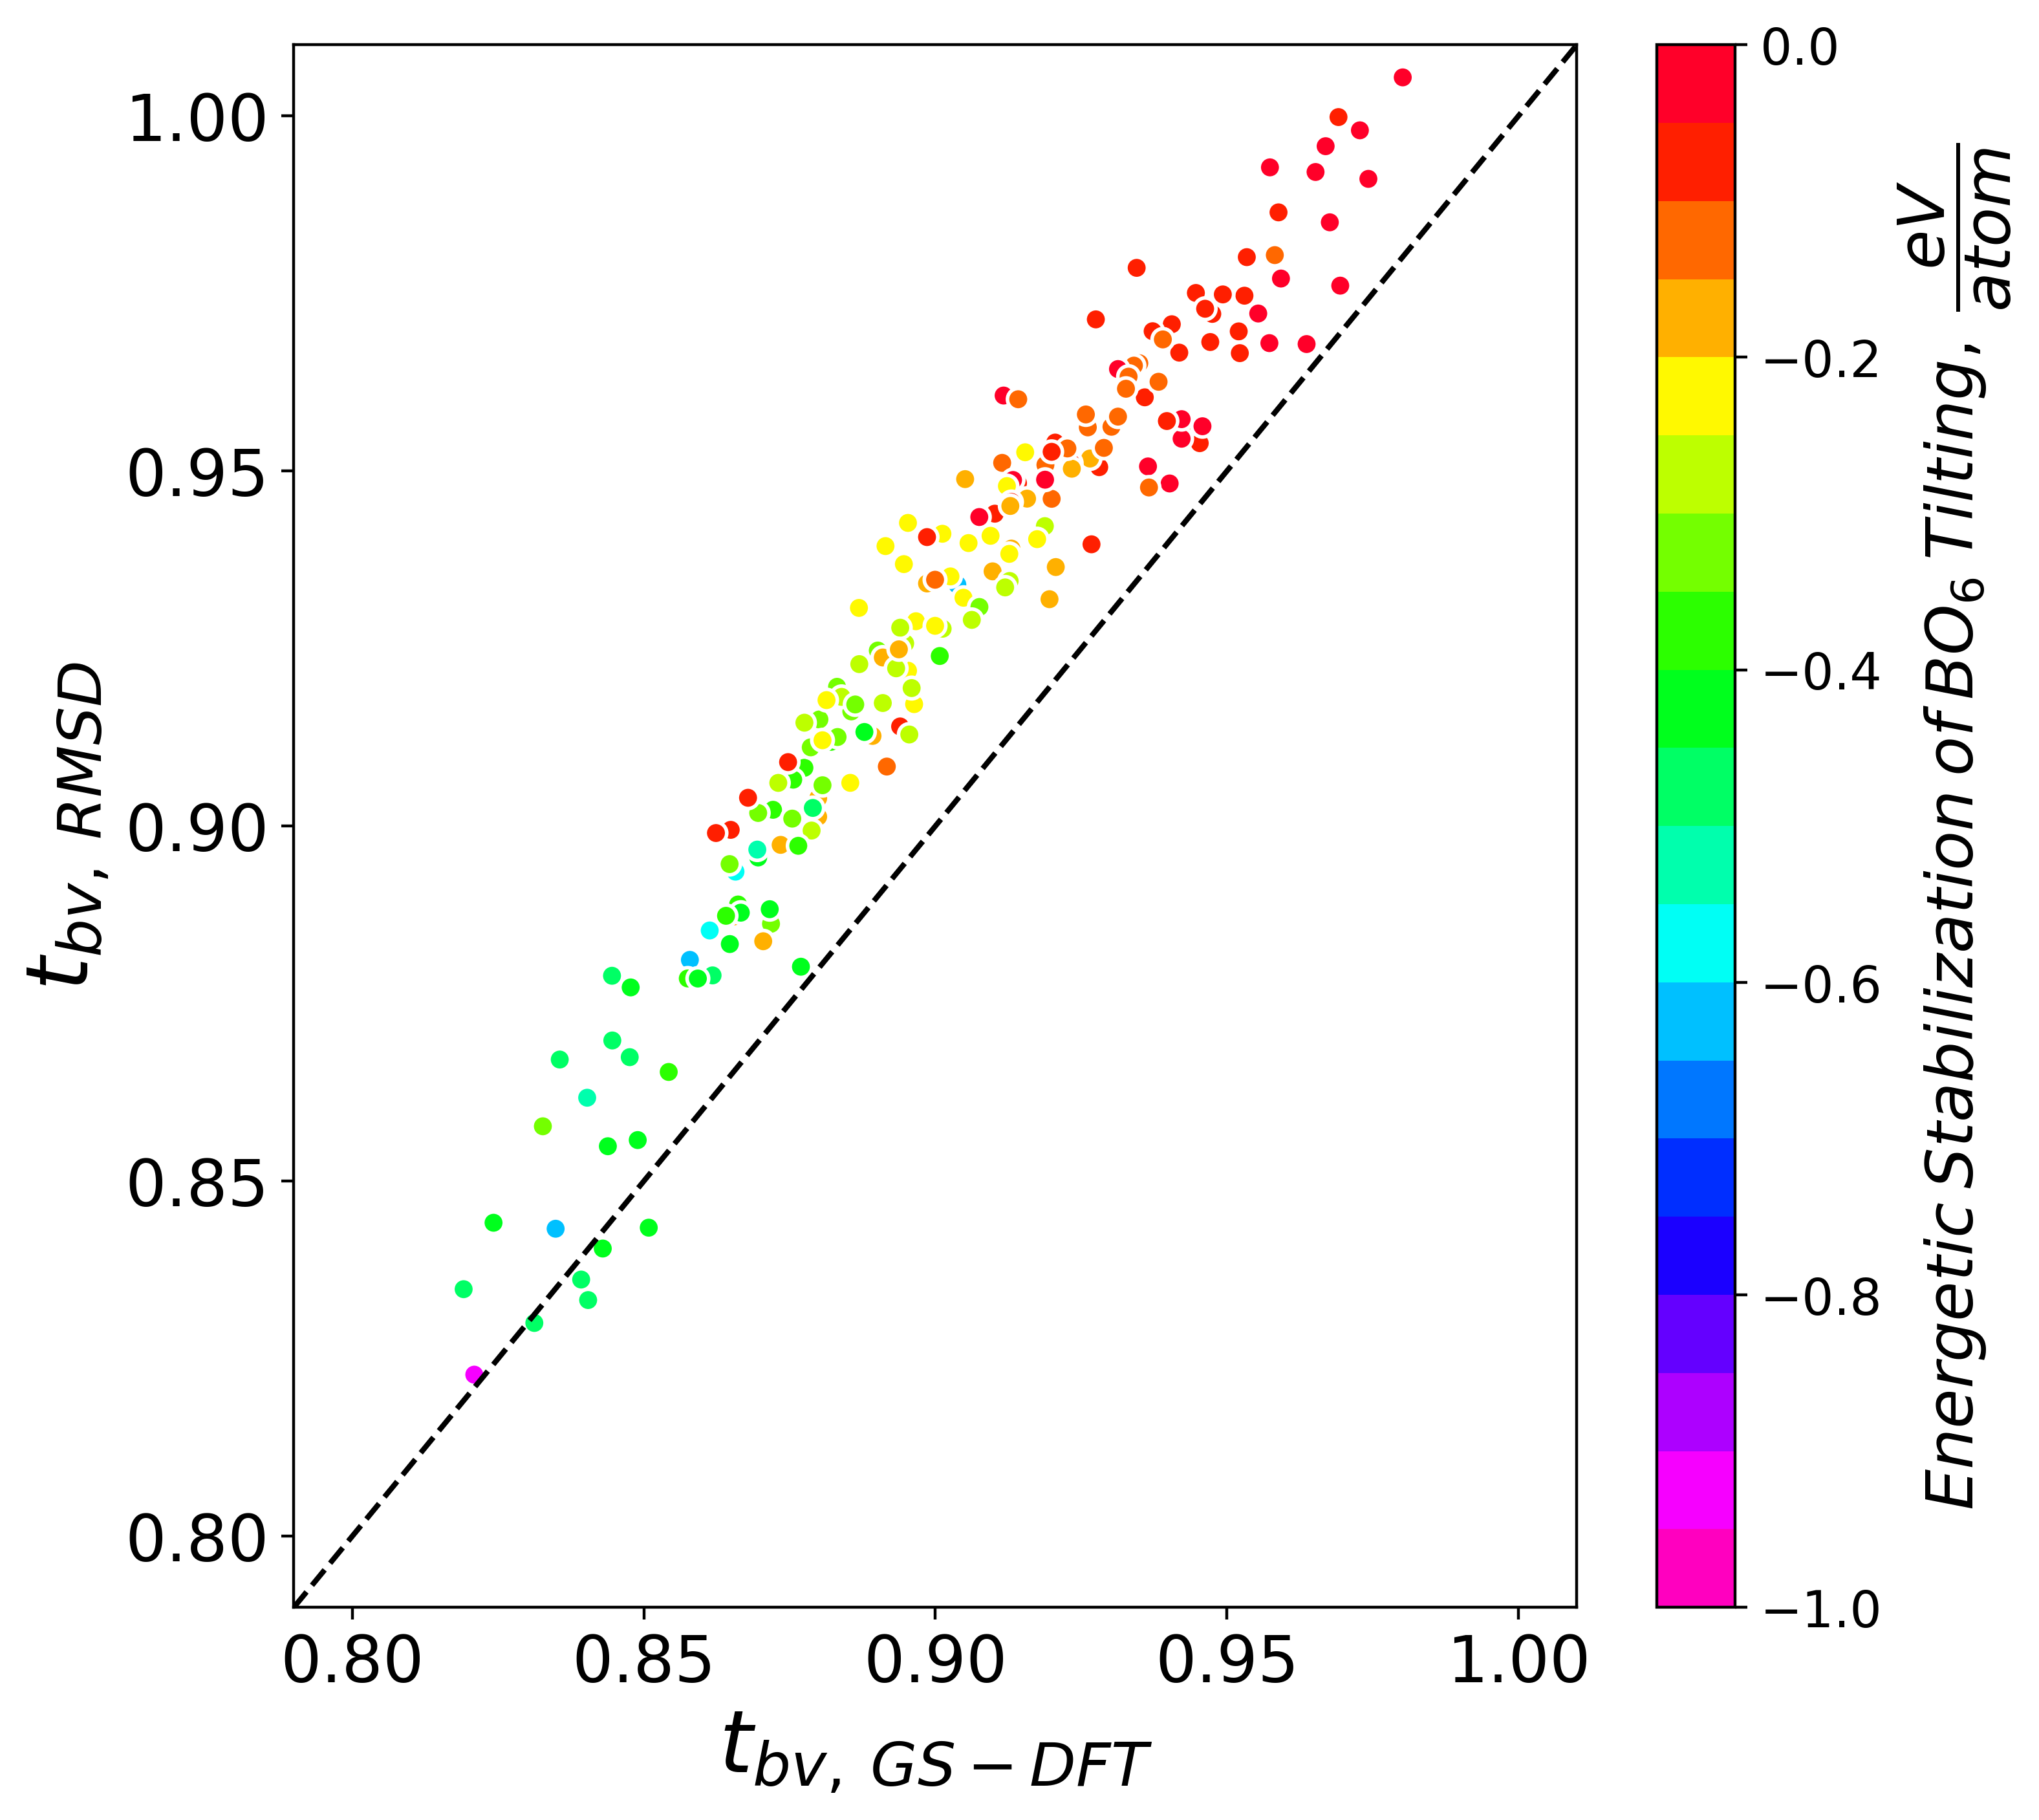

In [37]:
compare_tbvs(tbv_dct, g_rmsd_params_dct, g_08_params_dct, dct, name='figures/compare_tbvs.png')

In [8]:
from analysis import calculate_tbv_for_composition

In [18]:
tbv_rmsds = []
tbv_gs_dfts = []

for composition in list(dct.keys()):
    tbv_rmsd = calculate_tbv_for_composition(composition, tbv_dct, g_rmsd_params_dct)
    tbv_gs_dft = calculate_tbv_for_composition(composition, tbv_dct, g_08_params_dct)
    tbv_rmsds.append(tbv_rmsd)
    tbv_gs_dfts.append(tbv_gs_dft)

In [23]:
np.max(tbv_rmsds), np.min(tbv_rmsds), np.max(tbv_gs_dfts), np.min(tbv_gs_dfts)

(1.0054068855582423,
 0.8227610582968186,
 0.9801363648389323,
 0.8191096319304961)

## Get the publication thumbnail

In [16]:
from visualization import pub_thumbnail

In [9]:
with open('optimized_parameters/59_g_11_tilts_p_0.8_optimized_parameters_0.01_6.json') as json_file:
    g_08_params_dct = json.load(json_file)

g_08_params_dct['Cation'] = [Specie.from_dict(s) for s in g_08_params_dct['Cation']]
g_08_params_dct['Anion'] = [Specie.from_dict(s) for s in g_08_params_dct['Anion']]

In [20]:
thumbnail_gii = GIICalculator(params_dict=g_08_params_dct)
cmpd_energies = dct['LaTiO3']['energies']
cmpd_giis = [thumbnail_gii.GII(s) for s in dct['LaTiO3']['structures']]

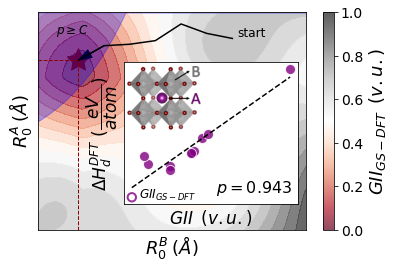

In [21]:
pub_thumbnail(cmpd_giis, cmpd_energies, name='figures/thumbnail.png')